In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 831)
(657450, 8)
validation
(74368, 831)
(74368, 8)
test
(91684, 831)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 1:50 - loss: 2.1437 - STD: 0.1011 - MAE: 0.2185

 4/66 [>.............................] - ETA: 1s - loss: 1.6502 - STD: 0.1286 - MAE: 0.1819  

 7/66 [==>...........................] - ETA: 1s - loss: 1.5186 - STD: 0.1705 - MAE: 0.1606

10/66 [===>..........................] - ETA: 1s - loss: 1.4602 - STD: 0.1843 - MAE: 0.1531

13/66 [====>.........................] - ETA: 1s - loss: 1.4295 - STD: 0.1851 - MAE: 0.1516

16/66 [======>.......................] - ETA: 1s - loss: 1.4111 - STD: 0.1847 - MAE: 0.1511

19/66 [=======>......................] - ETA: 1s - loss: 1.3952 - STD: 0.1869 - MAE: 0.1497

21/66 [========>.....................] - ETA: 1s - loss: 1.3900 - STD: 0.1890 - MAE: 0.1487

24/66 [=========>....................] - ETA: 0s - loss: 1.3834 - STD: 0.1912 - MAE: 0.1476

27/66 [===========>..................] - ETA: 0s - loss: 1.3767 - STD: 0.1914 - MAE: 0.1473

30/66 [============>.................] - ETA: 0s - loss: 1.3708 - STD: 0.1906 - MAE: 0.1474

32/66 [=============>................] - ETA: 1s - loss: 1.3669 - STD: 0.1903 - MAE: 0.1474

35/66 [==============>...............] - ETA: 1s - loss: 1.3627 - STD: 0.1907 - MAE: 0.1471

38/66 [================>.............] - ETA: 1s - loss: 1.3586 - STD: 0.1915 - MAE: 0.1467

41/66 [=================>............] - ETA: 1s - loss: 1.3550 - STD: 0.1920 - MAE: 0.1464

44/66 [===================>..........] - ETA: 1s - loss: 1.3519 - STD: 0.1919 - MAE: 0.1463

47/66 [====================>.........] - ETA: 0s - loss: 1.3493 - STD: 0.1916 - MAE: 0.1463

50/66 [=====================>........] - ETA: 0s - loss: 1.3470 - STD: 0.1915 - MAE: 0.1463

53/66 [=======================>......] - ETA: 0s - loss: 1.3443 - STD: 0.1916 - MAE: 0.1462

56/66 [========================>.....] - ETA: 0s - loss: 1.3426 - STD: 0.1918 - MAE: 0.1461

59/66 [=========================>....] - ETA: 0s - loss: 1.3402 - STD: 0.1918 - MAE: 0.1460

62/66 [===========================>..] - ETA: 0s - loss: 1.3390 - STD: 0.1917 - MAE: 0.1460

65/66 [============================>.] - ETA: 0s - loss: 1.3376 - STD: 0.1916 - MAE: 0.1460

66/66 [==============================] - 5s 50ms/step - loss: 1.3371 - STD: 0.1916 - MAE: 0.1460 - val_loss: 1.2434 - val_STD: 0.1922 - val_MAE: 0.1417


Epoch 2/10000


 1/66 [..............................] - ETA: 2s - loss: 1.3234 - STD: 0.1922 - MAE: 0.1457

 4/66 [>.............................] - ETA: 1s - loss: 1.3215 - STD: 0.1922 - MAE: 0.1456

 7/66 [==>...........................] - ETA: 1s - loss: 1.3145 - STD: 0.1914 - MAE: 0.1456

10/66 [===>..........................] - ETA: 1s - loss: 1.3138 - STD: 0.1913 - MAE: 0.1456

13/66 [====>.........................] - ETA: 1s - loss: 1.3128 - STD: 0.1915 - MAE: 0.1454

16/66 [======>.......................] - ETA: 1s - loss: 1.3114 - STD: 0.1917 - MAE: 0.1453

19/66 [=======>......................] - ETA: 1s - loss: 1.3099 - STD: 0.1917 - MAE: 0.1453

22/66 [=========>....................] - ETA: 0s - loss: 1.3101 - STD: 0.1917 - MAE: 0.1452

25/66 [==========>...................] - ETA: 0s - loss: 1.3094 - STD: 0.1918 - MAE: 0.1452

28/66 [===========>..................] - ETA: 0s - loss: 1.3085 - STD: 0.1919 - MAE: 0.1451

31/66 [=============>................] - ETA: 0s - loss: 1.3081 - STD: 0.1919 - MAE: 0.1451

34/66 [==============>...............] - ETA: 0s - loss: 1.3064 - STD: 0.1919 - MAE: 0.1450

37/66 [===============>..............] - ETA: 0s - loss: 1.3051 - STD: 0.1921 - MAE: 0.1448

39/66 [================>.............] - ETA: 0s - loss: 1.3048 - STD: 0.1922 - MAE: 0.1447

42/66 [==================>...........] - ETA: 0s - loss: 1.3043 - STD: 0.1922 - MAE: 0.1447

45/66 [===================>..........] - ETA: 0s - loss: 1.3032 - STD: 0.1921 - MAE: 0.1447

48/66 [====================>.........] - ETA: 0s - loss: 1.3024 - STD: 0.1919 - MAE: 0.1448

51/66 [======================>.......] - ETA: 0s - loss: 1.3012 - STD: 0.1917 - MAE: 0.1448

54/66 [=======================>......] - ETA: 0s - loss: 1.2992 - STD: 0.1920 - MAE: 0.1446

57/66 [========================>.....] - ETA: 0s - loss: 1.2969 - STD: 0.1920 - MAE: 0.1444

60/66 [==========================>...] - ETA: 0s - loss: 1.2944 - STD: 0.1923 - MAE: 0.1442

63/66 [===========================>..] - ETA: 0s - loss: 1.2927 - STD: 0.1924 - MAE: 0.1441

66/66 [==============================] - ETA: 0s - loss: 1.2913 - STD: 0.1924 - MAE: 0.1441

66/66 [==============================] - 2s 26ms/step - loss: 1.2913 - STD: 0.1924 - MAE: 0.1441 - val_loss: 1.1673 - val_STD: 0.1934 - val_MAE: 0.1372


Epoch 3/10000


 1/66 [..............................] - ETA: 3s - loss: 1.2559 - STD: 0.1972 - MAE: 0.1407

 3/66 [>.............................] - ETA: 1s - loss: 1.2452 - STD: 0.1965 - MAE: 0.1405

 6/66 [=>............................] - ETA: 1s - loss: 1.2412 - STD: 0.1968 - MAE: 0.1402

 9/66 [===>..........................] - ETA: 1s - loss: 1.2382 - STD: 0.1970 - MAE: 0.1401

12/66 [====>.........................] - ETA: 1s - loss: 1.2345 - STD: 0.1970 - MAE: 0.1401

15/66 [=====>........................] - ETA: 1s - loss: 1.2287 - STD: 0.1972 - MAE: 0.1398

18/66 [=======>......................] - ETA: 1s - loss: 1.2267 - STD: 0.1971 - MAE: 0.1398

21/66 [========>.....................] - ETA: 1s - loss: 1.2208 - STD: 0.1977 - MAE: 0.1394

24/66 [=========>....................] - ETA: 0s - loss: 1.2183 - STD: 0.1977 - MAE: 0.1394

27/66 [===========>..................] - ETA: 0s - loss: 1.2154 - STD: 0.1979 - MAE: 0.1393

30/66 [============>.................] - ETA: 0s - loss: 1.2112 - STD: 0.1981 - MAE: 0.1391

33/66 [==============>...............] - ETA: 0s - loss: 1.2085 - STD: 0.1984 - MAE: 0.1389

36/66 [===============>..............] - ETA: 0s - loss: 1.2057 - STD: 0.1986 - MAE: 0.1387

39/66 [================>.............] - ETA: 0s - loss: 1.2031 - STD: 0.1987 - MAE: 0.1386

42/66 [==================>...........] - ETA: 0s - loss: 1.2010 - STD: 0.1989 - MAE: 0.1385

45/66 [===================>..........] - ETA: 0s - loss: 1.1989 - STD: 0.1989 - MAE: 0.1384

48/66 [====================>.........] - ETA: 0s - loss: 1.1962 - STD: 0.1991 - MAE: 0.1383

51/66 [======================>.......] - ETA: 0s - loss: 1.1936 - STD: 0.1994 - MAE: 0.1381

54/66 [=======================>......] - ETA: 0s - loss: 1.1917 - STD: 0.1996 - MAE: 0.1380

57/66 [========================>.....] - ETA: 0s - loss: 1.1895 - STD: 0.1998 - MAE: 0.1378

60/66 [==========================>...] - ETA: 0s - loss: 1.1878 - STD: 0.1999 - MAE: 0.1378

63/66 [===========================>..] - ETA: 0s - loss: 1.1860 - STD: 0.1999 - MAE: 0.1377

66/66 [==============================] - ETA: 0s - loss: 1.1841 - STD: 0.2000 - MAE: 0.1376

66/66 [==============================] - 2s 27ms/step - loss: 1.1841 - STD: 0.2000 - MAE: 0.1376 - val_loss: 1.0601 - val_STD: 0.1914 - val_MAE: 0.1342


Epoch 4/10000


 1/66 [..............................] - ETA: 2s - loss: 1.1448 - STD: 0.2013 - MAE: 0.1362

 3/66 [>.............................] - ETA: 1s - loss: 1.1403 - STD: 0.2017 - MAE: 0.1358

 6/66 [=>............................] - ETA: 1s - loss: 1.1362 - STD: 0.2021 - MAE: 0.1355

 9/66 [===>..........................] - ETA: 1s - loss: 1.1354 - STD: 0.2023 - MAE: 0.1354

12/66 [====>.........................] - ETA: 1s - loss: 1.1299 - STD: 0.2027 - MAE: 0.1350

15/66 [=====>........................] - ETA: 1s - loss: 1.1258 - STD: 0.2032 - MAE: 0.1345

18/66 [=======>......................] - ETA: 1s - loss: 1.1252 - STD: 0.2031 - MAE: 0.1345

21/66 [========>.....................] - ETA: 1s - loss: 1.1227 - STD: 0.2028 - MAE: 0.1344

24/66 [=========>....................] - ETA: 1s - loss: 1.1205 - STD: 0.2031 - MAE: 0.1342

27/66 [===========>..................] - ETA: 0s - loss: 1.1175 - STD: 0.2031 - MAE: 0.1340

30/66 [============>.................] - ETA: 0s - loss: 1.1129 - STD: 0.2037 - MAE: 0.1335

33/66 [==============>...............] - ETA: 0s - loss: 1.1088 - STD: 0.2043 - MAE: 0.1330

36/66 [===============>..............] - ETA: 0s - loss: 1.1052 - STD: 0.2047 - MAE: 0.1327

39/66 [================>.............] - ETA: 0s - loss: 1.1015 - STD: 0.2048 - MAE: 0.1324

42/66 [==================>...........] - ETA: 0s - loss: 1.0981 - STD: 0.2053 - MAE: 0.1320

45/66 [===================>..........] - ETA: 0s - loss: 1.0947 - STD: 0.2061 - MAE: 0.1315

47/66 [====================>.........] - ETA: 0s - loss: 1.0920 - STD: 0.2062 - MAE: 0.1313

50/66 [=====================>........] - ETA: 0s - loss: 1.0886 - STD: 0.2066 - MAE: 0.1310

53/66 [=======================>......] - ETA: 0s - loss: 1.0854 - STD: 0.2072 - MAE: 0.1306

56/66 [========================>.....] - ETA: 0s - loss: 1.0822 - STD: 0.2076 - MAE: 0.1302

59/66 [=========================>....] - ETA: 0s - loss: 1.0793 - STD: 0.2081 - MAE: 0.1299

62/66 [===========================>..] - ETA: 0s - loss: 1.0761 - STD: 0.2085 - MAE: 0.1296

65/66 [============================>.] - ETA: 0s - loss: 1.0730 - STD: 0.2088 - MAE: 0.1293

66/66 [==============================] - 2s 27ms/step - loss: 1.0720 - STD: 0.2090 - MAE: 0.1292 - val_loss: 0.9214 - val_STD: 0.2000 - val_MAE: 0.1231


Epoch 5/10000


 1/66 [..............................] - ETA: 3s - loss: 1.0095 - STD: 0.2086 - MAE: 0.1264

 4/66 [>.............................] - ETA: 1s - loss: 1.0029 - STD: 0.2169 - MAE: 0.1225

 7/66 [==>...........................] - ETA: 1s - loss: 1.0047 - STD: 0.2160 - MAE: 0.1229

10/66 [===>..........................] - ETA: 1s - loss: 1.0003 - STD: 0.2159 - MAE: 0.1227

13/66 [====>.........................] - ETA: 1s - loss: 1.0007 - STD: 0.2165 - MAE: 0.1224

15/66 [=====>........................] - ETA: 1s - loss: 0.9981 - STD: 0.2176 - MAE: 0.1218

18/66 [=======>......................] - ETA: 1s - loss: 0.9955 - STD: 0.2176 - MAE: 0.1217

21/66 [========>.....................] - ETA: 1s - loss: 0.9934 - STD: 0.2177 - MAE: 0.1215

24/66 [=========>....................] - ETA: 1s - loss: 0.9909 - STD: 0.2184 - MAE: 0.1211

27/66 [===========>..................] - ETA: 0s - loss: 0.9888 - STD: 0.2188 - MAE: 0.1209

30/66 [============>.................] - ETA: 0s - loss: 0.9863 - STD: 0.2192 - MAE: 0.1206

33/66 [==============>...............] - ETA: 0s - loss: 0.9834 - STD: 0.2194 - MAE: 0.1203

36/66 [===============>..............] - ETA: 0s - loss: 0.9819 - STD: 0.2195 - MAE: 0.1202

39/66 [================>.............] - ETA: 0s - loss: 0.9798 - STD: 0.2201 - MAE: 0.1199

42/66 [==================>...........] - ETA: 0s - loss: 0.9781 - STD: 0.2204 - MAE: 0.1197

45/66 [===================>..........] - ETA: 0s - loss: 0.9765 - STD: 0.2206 - MAE: 0.1195

48/66 [====================>.........] - ETA: 0s - loss: 0.9756 - STD: 0.2208 - MAE: 0.1194

51/66 [======================>.......] - ETA: 0s - loss: 0.9747 - STD: 0.2209 - MAE: 0.1193

54/66 [=======================>......] - ETA: 0s - loss: 0.9729 - STD: 0.2210 - MAE: 0.1192

57/66 [========================>.....] - ETA: 0s - loss: 0.9706 - STD: 0.2214 - MAE: 0.1189

60/66 [==========================>...] - ETA: 0s - loss: 0.9693 - STD: 0.2214 - MAE: 0.1189

63/66 [===========================>..] - ETA: 0s - loss: 0.9678 - STD: 0.2215 - MAE: 0.1188

66/66 [==============================] - ETA: 0s - loss: 0.9661 - STD: 0.2217 - MAE: 0.1187

66/66 [==============================] - 2s 27ms/step - loss: 0.9661 - STD: 0.2217 - MAE: 0.1187 - val_loss: 0.8593 - val_STD: 0.2127 - val_MAE: 0.1155


Epoch 6/10000


 1/66 [..............................] - ETA: 3s - loss: 0.9434 - STD: 0.2205 - MAE: 0.1184

 4/66 [>.............................] - ETA: 1s - loss: 0.9349 - STD: 0.2245 - MAE: 0.1163

 7/66 [==>...........................] - ETA: 1s - loss: 0.9327 - STD: 0.2257 - MAE: 0.1157

10/66 [===>..........................] - ETA: 1s - loss: 0.9330 - STD: 0.2253 - MAE: 0.1160

13/66 [====>.........................] - ETA: 1s - loss: 0.9306 - STD: 0.2252 - MAE: 0.1159

16/66 [======>.......................] - ETA: 1s - loss: 0.9286 - STD: 0.2253 - MAE: 0.1158

19/66 [=======>......................] - ETA: 1s - loss: 0.9259 - STD: 0.2257 - MAE: 0.1154

22/66 [=========>....................] - ETA: 1s - loss: 0.9247 - STD: 0.2257 - MAE: 0.1154

25/66 [==========>...................] - ETA: 0s - loss: 0.9233 - STD: 0.2258 - MAE: 0.1153

28/66 [===========>..................] - ETA: 0s - loss: 0.9214 - STD: 0.2259 - MAE: 0.1152

30/66 [============>.................] - ETA: 0s - loss: 0.9206 - STD: 0.2262 - MAE: 0.1150

33/66 [==============>...............] - ETA: 0s - loss: 0.9203 - STD: 0.2261 - MAE: 0.1151

36/66 [===============>..............] - ETA: 0s - loss: 0.9192 - STD: 0.2260 - MAE: 0.1150

39/66 [================>.............] - ETA: 0s - loss: 0.9180 - STD: 0.2261 - MAE: 0.1150

42/66 [==================>...........] - ETA: 0s - loss: 0.9165 - STD: 0.2263 - MAE: 0.1149

45/66 [===================>..........] - ETA: 0s - loss: 0.9156 - STD: 0.2264 - MAE: 0.1148

48/66 [====================>.........] - ETA: 0s - loss: 0.9145 - STD: 0.2264 - MAE: 0.1147

51/66 [======================>.......] - ETA: 0s - loss: 0.9139 - STD: 0.2265 - MAE: 0.1147

54/66 [=======================>......] - ETA: 0s - loss: 0.9121 - STD: 0.2266 - MAE: 0.1146

57/66 [========================>.....] - ETA: 0s - loss: 0.9115 - STD: 0.2266 - MAE: 0.1146

60/66 [==========================>...] - ETA: 0s - loss: 0.9101 - STD: 0.2267 - MAE: 0.1145

63/66 [===========================>..] - ETA: 0s - loss: 0.9088 - STD: 0.2268 - MAE: 0.1144

66/66 [==============================] - ETA: 0s - loss: 0.9074 - STD: 0.2269 - MAE: 0.1143

66/66 [==============================] - 2s 27ms/step - loss: 0.9074 - STD: 0.2269 - MAE: 0.1143 - val_loss: 0.8188 - val_STD: 0.2215 - val_MAE: 0.1107


Epoch 7/10000


 1/66 [..............................] - ETA: 3s - loss: 0.8792 - STD: 0.2275 - MAE: 0.1132

 4/66 [>.............................] - ETA: 1s - loss: 0.8822 - STD: 0.2289 - MAE: 0.1127

 6/66 [=>............................] - ETA: 1s - loss: 0.8839 - STD: 0.2293 - MAE: 0.1125

 9/66 [===>..........................] - ETA: 1s - loss: 0.8830 - STD: 0.2283 - MAE: 0.1130

12/66 [====>.........................] - ETA: 1s - loss: 0.8794 - STD: 0.2288 - MAE: 0.1125

15/66 [=====>........................] - ETA: 1s - loss: 0.8778 - STD: 0.2290 - MAE: 0.1123

18/66 [=======>......................] - ETA: 1s - loss: 0.8774 - STD: 0.2290 - MAE: 0.1123

21/66 [========>.....................] - ETA: 1s - loss: 0.8772 - STD: 0.2294 - MAE: 0.1121

23/66 [=========>....................] - ETA: 1s - loss: 0.8773 - STD: 0.2291 - MAE: 0.1123

26/66 [==========>...................] - ETA: 0s - loss: 0.8759 - STD: 0.2293 - MAE: 0.1121

29/66 [============>.................] - ETA: 0s - loss: 0.8770 - STD: 0.2294 - MAE: 0.1122

32/66 [=============>................] - ETA: 0s - loss: 0.8767 - STD: 0.2293 - MAE: 0.1122

35/66 [==============>...............] - ETA: 0s - loss: 0.8763 - STD: 0.2294 - MAE: 0.1121

38/66 [================>.............] - ETA: 0s - loss: 0.8763 - STD: 0.2295 - MAE: 0.1121

40/66 [=================>............] - ETA: 0s - loss: 0.8759 - STD: 0.2295 - MAE: 0.1121

43/66 [==================>...........] - ETA: 0s - loss: 0.8747 - STD: 0.2296 - MAE: 0.1120

46/66 [===================>..........] - ETA: 0s - loss: 0.8738 - STD: 0.2297 - MAE: 0.1119

49/66 [=====================>........] - ETA: 0s - loss: 0.8726 - STD: 0.2297 - MAE: 0.1118

52/66 [======================>.......] - ETA: 0s - loss: 0.8717 - STD: 0.2298 - MAE: 0.1118

55/66 [========================>.....] - ETA: 0s - loss: 0.8715 - STD: 0.2298 - MAE: 0.1117

58/66 [=========================>....] - ETA: 0s - loss: 0.8723 - STD: 0.2298 - MAE: 0.1118

61/66 [==========================>...] - ETA: 0s - loss: 0.8724 - STD: 0.2300 - MAE: 0.1117

64/66 [============================>.] - ETA: 0s - loss: 0.8721 - STD: 0.2302 - MAE: 0.1116

66/66 [==============================] - 2s 27ms/step - loss: 0.8726 - STD: 0.2300 - MAE: 0.1118 - val_loss: 0.8174 - val_STD: 0.2344 - val_MAE: 0.1054


Epoch 8/10000


 1/66 [..............................] - ETA: 2s - loss: 0.8978 - STD: 0.2388 - MAE: 0.1095

 4/66 [>.............................] - ETA: 1s - loss: 0.8686 - STD: 0.2318 - MAE: 0.1110

 7/66 [==>...........................] - ETA: 1s - loss: 0.8656 - STD: 0.2308 - MAE: 0.1114

10/66 [===>..........................] - ETA: 1s - loss: 0.8620 - STD: 0.2314 - MAE: 0.1109

13/66 [====>.........................] - ETA: 1s - loss: 0.8578 - STD: 0.2315 - MAE: 0.1106

16/66 [======>.......................] - ETA: 1s - loss: 0.8564 - STD: 0.2309 - MAE: 0.1108

19/66 [=======>......................] - ETA: 1s - loss: 0.8543 - STD: 0.2314 - MAE: 0.1104

22/66 [=========>....................] - ETA: 1s - loss: 0.8530 - STD: 0.2317 - MAE: 0.1102

25/66 [==========>...................] - ETA: 0s - loss: 0.8525 - STD: 0.2320 - MAE: 0.1100

28/66 [===========>..................] - ETA: 0s - loss: 0.8514 - STD: 0.2318 - MAE: 0.1101

31/66 [=============>................] - ETA: 0s - loss: 0.8515 - STD: 0.2318 - MAE: 0.1101

34/66 [==============>...............] - ETA: 0s - loss: 0.8518 - STD: 0.2320 - MAE: 0.1100

37/66 [===============>..............] - ETA: 0s - loss: 0.8524 - STD: 0.2319 - MAE: 0.1101

40/66 [=================>............] - ETA: 0s - loss: 0.8531 - STD: 0.2319 - MAE: 0.1102

43/66 [==================>...........] - ETA: 0s - loss: 0.8535 - STD: 0.2319 - MAE: 0.1102

46/66 [===================>..........] - ETA: 0s - loss: 0.8541 - STD: 0.2318 - MAE: 0.1103

49/66 [=====================>........] - ETA: 0s - loss: 0.8538 - STD: 0.2320 - MAE: 0.1102

52/66 [======================>.......] - ETA: 0s - loss: 0.8538 - STD: 0.2319 - MAE: 0.1102

55/66 [========================>.....] - ETA: 0s - loss: 0.8532 - STD: 0.2320 - MAE: 0.1102

58/66 [=========================>....] - ETA: 0s - loss: 0.8526 - STD: 0.2321 - MAE: 0.1101

61/66 [==========================>...] - ETA: 0s - loss: 0.8519 - STD: 0.2320 - MAE: 0.1101

64/66 [============================>.] - ETA: 0s - loss: 0.8515 - STD: 0.2322 - MAE: 0.1100

66/66 [==============================] - 2s 27ms/step - loss: 0.8515 - STD: 0.2321 - MAE: 0.1100 - val_loss: 0.7824 - val_STD: 0.2288 - val_MAE: 0.1065


Epoch 9/10000


 1/66 [..............................] - ETA: 3s - loss: 0.8441 - STD: 0.2326 - MAE: 0.1094

 4/66 [>.............................] - ETA: 1s - loss: 0.8320 - STD: 0.2343 - MAE: 0.1080

 7/66 [==>...........................] - ETA: 1s - loss: 0.8356 - STD: 0.2330 - MAE: 0.1088

10/66 [===>..........................] - ETA: 1s - loss: 0.8316 - STD: 0.2336 - MAE: 0.1084

13/66 [====>.........................] - ETA: 1s - loss: 0.8306 - STD: 0.2334 - MAE: 0.1085

16/66 [======>.......................] - ETA: 1s - loss: 0.8314 - STD: 0.2335 - MAE: 0.1085

19/66 [=======>......................] - ETA: 1s - loss: 0.8309 - STD: 0.2337 - MAE: 0.1083

22/66 [=========>....................] - ETA: 1s - loss: 0.8315 - STD: 0.2335 - MAE: 0.1085

24/66 [=========>....................] - ETA: 0s - loss: 0.8319 - STD: 0.2335 - MAE: 0.1085

27/66 [===========>..................] - ETA: 0s - loss: 0.8316 - STD: 0.2337 - MAE: 0.1084

30/66 [============>.................] - ETA: 0s - loss: 0.8334 - STD: 0.2337 - MAE: 0.1085

33/66 [==============>...............] - ETA: 0s - loss: 0.8336 - STD: 0.2336 - MAE: 0.1086

36/66 [===============>..............] - ETA: 0s - loss: 0.8343 - STD: 0.2337 - MAE: 0.1086

39/66 [================>.............] - ETA: 0s - loss: 0.8341 - STD: 0.2336 - MAE: 0.1086

42/66 [==================>...........] - ETA: 0s - loss: 0.8341 - STD: 0.2338 - MAE: 0.1085

45/66 [===================>..........] - ETA: 0s - loss: 0.8338 - STD: 0.2336 - MAE: 0.1086

47/66 [====================>.........] - ETA: 0s - loss: 0.8341 - STD: 0.2337 - MAE: 0.1086

49/66 [=====================>........] - ETA: 0s - loss: 0.8338 - STD: 0.2338 - MAE: 0.1085

52/66 [======================>.......] - ETA: 0s - loss: 0.8333 - STD: 0.2338 - MAE: 0.1085

55/66 [========================>.....] - ETA: 0s - loss: 0.8332 - STD: 0.2337 - MAE: 0.1086

58/66 [=========================>....] - ETA: 0s - loss: 0.8333 - STD: 0.2339 - MAE: 0.1085

61/66 [==========================>...] - ETA: 0s - loss: 0.8328 - STD: 0.2339 - MAE: 0.1085

64/66 [============================>.] - ETA: 0s - loss: 0.8327 - STD: 0.2339 - MAE: 0.1084

66/66 [==============================] - 2s 27ms/step - loss: 0.8328 - STD: 0.2338 - MAE: 0.1085 - val_loss: 0.7733 - val_STD: 0.2332 - val_MAE: 0.1040


Epoch 10/10000


 1/66 [..............................] - ETA: 3s - loss: 0.8357 - STD: 0.2371 - MAE: 0.1072

 4/66 [>.............................] - ETA: 1s - loss: 0.8258 - STD: 0.2353 - MAE: 0.1075

 7/66 [==>...........................] - ETA: 1s - loss: 0.8272 - STD: 0.2360 - MAE: 0.1072

10/66 [===>..........................] - ETA: 1s - loss: 0.8318 - STD: 0.2347 - MAE: 0.1080

13/66 [====>.........................] - ETA: 1s - loss: 0.8317 - STD: 0.2351 - MAE: 0.1078

16/66 [======>.......................] - ETA: 1s - loss: 0.8309 - STD: 0.2347 - MAE: 0.1080

19/66 [=======>......................] - ETA: 1s - loss: 0.8312 - STD: 0.2352 - MAE: 0.1078

22/66 [=========>....................] - ETA: 1s - loss: 0.8327 - STD: 0.2348 - MAE: 0.1080

25/66 [==========>...................] - ETA: 0s - loss: 0.8323 - STD: 0.2349 - MAE: 0.1080

28/66 [===========>..................] - ETA: 0s - loss: 0.8314 - STD: 0.2348 - MAE: 0.1080

31/66 [=============>................] - ETA: 0s - loss: 0.8323 - STD: 0.2349 - MAE: 0.1080

34/66 [==============>...............] - ETA: 0s - loss: 0.8323 - STD: 0.2350 - MAE: 0.1079

37/66 [===============>..............] - ETA: 0s - loss: 0.8313 - STD: 0.2347 - MAE: 0.1080

40/66 [=================>............] - ETA: 0s - loss: 0.8305 - STD: 0.2348 - MAE: 0.1079

42/66 [==================>...........] - ETA: 0s - loss: 0.8303 - STD: 0.2348 - MAE: 0.1079

45/66 [===================>..........] - ETA: 0s - loss: 0.8291 - STD: 0.2349 - MAE: 0.1078

48/66 [====================>.........] - ETA: 0s - loss: 0.8283 - STD: 0.2348 - MAE: 0.1078

51/66 [======================>.......] - ETA: 0s - loss: 0.8277 - STD: 0.2349 - MAE: 0.1078

54/66 [=======================>......] - ETA: 0s - loss: 0.8268 - STD: 0.2350 - MAE: 0.1077

57/66 [========================>.....] - ETA: 0s - loss: 0.8264 - STD: 0.2351 - MAE: 0.1076

60/66 [==========================>...] - ETA: 0s - loss: 0.8259 - STD: 0.2350 - MAE: 0.1076

63/66 [===========================>..] - ETA: 0s - loss: 0.8256 - STD: 0.2350 - MAE: 0.1076

66/66 [==============================] - ETA: 0s - loss: 0.8252 - STD: 0.2351 - MAE: 0.1076

66/66 [==============================] - 2s 27ms/step - loss: 0.8252 - STD: 0.2351 - MAE: 0.1076 - val_loss: 0.7631 - val_STD: 0.2316 - val_MAE: 0.1047


Epoch 11/10000


 1/66 [..............................] - ETA: 3s - loss: 0.8132 - STD: 0.2357 - MAE: 0.1067

 3/66 [>.............................] - ETA: 1s - loss: 0.8049 - STD: 0.2354 - MAE: 0.1065

 6/66 [=>............................] - ETA: 1s - loss: 0.8108 - STD: 0.2355 - MAE: 0.1069

 9/66 [===>..........................] - ETA: 1s - loss: 0.8112 - STD: 0.2354 - MAE: 0.1069

12/66 [====>.........................] - ETA: 1s - loss: 0.8087 - STD: 0.2357 - MAE: 0.1066

15/66 [=====>........................] - ETA: 1s - loss: 0.8079 - STD: 0.2361 - MAE: 0.1063

18/66 [=======>......................] - ETA: 1s - loss: 0.8093 - STD: 0.2362 - MAE: 0.1063

21/66 [========>.....................] - ETA: 1s - loss: 0.8096 - STD: 0.2359 - MAE: 0.1065

24/66 [=========>....................] - ETA: 1s - loss: 0.8097 - STD: 0.2360 - MAE: 0.1065

27/66 [===========>..................] - ETA: 0s - loss: 0.8084 - STD: 0.2361 - MAE: 0.1064

30/66 [============>.................] - ETA: 0s - loss: 0.8091 - STD: 0.2361 - MAE: 0.1064

33/66 [==============>...............] - ETA: 0s - loss: 0.8099 - STD: 0.2361 - MAE: 0.1065

36/66 [===============>..............] - ETA: 0s - loss: 0.8085 - STD: 0.2361 - MAE: 0.1064

39/66 [================>.............] - ETA: 0s - loss: 0.8085 - STD: 0.2360 - MAE: 0.1064

42/66 [==================>...........] - ETA: 0s - loss: 0.8070 - STD: 0.2362 - MAE: 0.1063

45/66 [===================>..........] - ETA: 0s - loss: 0.8069 - STD: 0.2362 - MAE: 0.1062

48/66 [====================>.........] - ETA: 0s - loss: 0.8074 - STD: 0.2363 - MAE: 0.1062

51/66 [======================>.......] - ETA: 0s - loss: 0.8075 - STD: 0.2363 - MAE: 0.1062

54/66 [=======================>......] - ETA: 0s - loss: 0.8087 - STD: 0.2363 - MAE: 0.1063

57/66 [========================>.....] - ETA: 0s - loss: 0.8095 - STD: 0.2362 - MAE: 0.1064

60/66 [==========================>...] - ETA: 0s - loss: 0.8099 - STD: 0.2362 - MAE: 0.1064

63/66 [===========================>..] - ETA: 0s - loss: 0.8095 - STD: 0.2362 - MAE: 0.1064

66/66 [==============================] - ETA: 0s - loss: 0.8093 - STD: 0.2362 - MAE: 0.1064

66/66 [==============================] - 2s 26ms/step - loss: 0.8093 - STD: 0.2362 - MAE: 0.1064 - val_loss: 0.7693 - val_STD: 0.2298 - val_MAE: 0.1055


Epoch 12/10000


 1/66 [..............................] - ETA: 3s - loss: 0.8120 - STD: 0.2337 - MAE: 0.1077

 4/66 [>.............................] - ETA: 1s - loss: 0.8051 - STD: 0.2378 - MAE: 0.1054

 6/66 [=>............................] - ETA: 1s - loss: 0.8050 - STD: 0.2377 - MAE: 0.1055

 8/66 [==>...........................] - ETA: 1s - loss: 0.8036 - STD: 0.2374 - MAE: 0.1055

11/66 [====>.........................] - ETA: 1s - loss: 0.8027 - STD: 0.2373 - MAE: 0.1055

14/66 [=====>........................] - ETA: 1s - loss: 0.8016 - STD: 0.2373 - MAE: 0.1055

17/66 [======>.......................] - ETA: 1s - loss: 0.8004 - STD: 0.2373 - MAE: 0.1054

20/66 [========>.....................] - ETA: 1s - loss: 0.8005 - STD: 0.2371 - MAE: 0.1055

23/66 [=========>....................] - ETA: 1s - loss: 0.8008 - STD: 0.2373 - MAE: 0.1055

26/66 [==========>...................] - ETA: 0s - loss: 0.8004 - STD: 0.2372 - MAE: 0.1055

29/66 [============>.................] - ETA: 0s - loss: 0.8006 - STD: 0.2372 - MAE: 0.1055

32/66 [=============>................] - ETA: 0s - loss: 0.8001 - STD: 0.2374 - MAE: 0.1054

35/66 [==============>...............] - ETA: 0s - loss: 0.7996 - STD: 0.2373 - MAE: 0.1055

37/66 [===============>..............] - ETA: 0s - loss: 0.8003 - STD: 0.2373 - MAE: 0.1055

40/66 [=================>............] - ETA: 0s - loss: 0.8007 - STD: 0.2372 - MAE: 0.1055

43/66 [==================>...........] - ETA: 0s - loss: 0.8009 - STD: 0.2372 - MAE: 0.1056

46/66 [===================>..........] - ETA: 0s - loss: 0.8007 - STD: 0.2372 - MAE: 0.1056

49/66 [=====================>........] - ETA: 0s - loss: 0.8007 - STD: 0.2372 - MAE: 0.1056

52/66 [======================>.......] - ETA: 0s - loss: 0.8010 - STD: 0.2372 - MAE: 0.1056

55/66 [========================>.....] - ETA: 0s - loss: 0.8008 - STD: 0.2372 - MAE: 0.1056

58/66 [=========================>....] - ETA: 0s - loss: 0.8010 - STD: 0.2373 - MAE: 0.1055

61/66 [==========================>...] - ETA: 0s - loss: 0.8018 - STD: 0.2372 - MAE: 0.1056

64/66 [============================>.] - ETA: 0s - loss: 0.8018 - STD: 0.2373 - MAE: 0.1056

66/66 [==============================] - 2s 27ms/step - loss: 0.8011 - STD: 0.2373 - MAE: 0.1055 - val_loss: 0.7442 - val_STD: 0.2397 - val_MAE: 0.1000


Epoch 13/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7939 - STD: 0.2428 - MAE: 0.1025

 4/66 [>.............................] - ETA: 1s - loss: 0.7913 - STD: 0.2376 - MAE: 0.1050

 7/66 [==>...........................] - ETA: 1s - loss: 0.7922 - STD: 0.2381 - MAE: 0.1048

 9/66 [===>..........................] - ETA: 1s - loss: 0.7923 - STD: 0.2381 - MAE: 0.1047

12/66 [====>.........................] - ETA: 1s - loss: 0.7932 - STD: 0.2387 - MAE: 0.1046

15/66 [=====>........................] - ETA: 1s - loss: 0.7940 - STD: 0.2383 - MAE: 0.1048

18/66 [=======>......................] - ETA: 1s - loss: 0.7932 - STD: 0.2380 - MAE: 0.1049

21/66 [========>.....................] - ETA: 1s - loss: 0.7925 - STD: 0.2381 - MAE: 0.1048

24/66 [=========>....................] - ETA: 1s - loss: 0.7918 - STD: 0.2380 - MAE: 0.1048

27/66 [===========>..................] - ETA: 0s - loss: 0.7921 - STD: 0.2378 - MAE: 0.1049

30/66 [============>.................] - ETA: 0s - loss: 0.7916 - STD: 0.2380 - MAE: 0.1047

33/66 [==============>...............] - ETA: 0s - loss: 0.7930 - STD: 0.2380 - MAE: 0.1048

36/66 [===============>..............] - ETA: 0s - loss: 0.7925 - STD: 0.2381 - MAE: 0.1047

39/66 [================>.............] - ETA: 0s - loss: 0.7918 - STD: 0.2383 - MAE: 0.1047

42/66 [==================>...........] - ETA: 0s - loss: 0.7914 - STD: 0.2383 - MAE: 0.1046

45/66 [===================>..........] - ETA: 0s - loss: 0.7913 - STD: 0.2382 - MAE: 0.1046

48/66 [====================>.........] - ETA: 0s - loss: 0.7909 - STD: 0.2382 - MAE: 0.1046

51/66 [======================>.......] - ETA: 0s - loss: 0.7912 - STD: 0.2383 - MAE: 0.1046

54/66 [=======================>......] - ETA: 0s - loss: 0.7909 - STD: 0.2383 - MAE: 0.1046

57/66 [========================>.....] - ETA: 0s - loss: 0.7906 - STD: 0.2383 - MAE: 0.1046

60/66 [==========================>...] - ETA: 0s - loss: 0.7905 - STD: 0.2384 - MAE: 0.1045

63/66 [===========================>..] - ETA: 0s - loss: 0.7911 - STD: 0.2383 - MAE: 0.1046

66/66 [==============================] - ETA: 0s - loss: 0.7921 - STD: 0.2384 - MAE: 0.1046

66/66 [==============================] - 2s 26ms/step - loss: 0.7921 - STD: 0.2384 - MAE: 0.1046 - val_loss: 0.7681 - val_STD: 0.2316 - val_MAE: 0.1050


Epoch 14/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7946 - STD: 0.2336 - MAE: 0.1071

 4/66 [>.............................] - ETA: 1s - loss: 0.8066 - STD: 0.2378 - MAE: 0.1056

 7/66 [==>...........................] - ETA: 1s - loss: 0.8019 - STD: 0.2379 - MAE: 0.1053

10/66 [===>..........................] - ETA: 1s - loss: 0.7989 - STD: 0.2383 - MAE: 0.1050

13/66 [====>.........................] - ETA: 1s - loss: 0.7977 - STD: 0.2378 - MAE: 0.1052

16/66 [======>.......................] - ETA: 1s - loss: 0.7979 - STD: 0.2379 - MAE: 0.1052

19/66 [=======>......................] - ETA: 1s - loss: 0.7982 - STD: 0.2382 - MAE: 0.1050

22/66 [=========>....................] - ETA: 1s - loss: 0.7974 - STD: 0.2384 - MAE: 0.1049

25/66 [==========>...................] - ETA: 0s - loss: 0.7968 - STD: 0.2384 - MAE: 0.1048

28/66 [===========>..................] - ETA: 0s - loss: 0.7944 - STD: 0.2384 - MAE: 0.1047

31/66 [=============>................] - ETA: 0s - loss: 0.7933 - STD: 0.2384 - MAE: 0.1046

34/66 [==============>...............] - ETA: 0s - loss: 0.7920 - STD: 0.2385 - MAE: 0.1045

37/66 [===============>..............] - ETA: 0s - loss: 0.7902 - STD: 0.2388 - MAE: 0.1043

40/66 [=================>............] - ETA: 0s - loss: 0.7896 - STD: 0.2388 - MAE: 0.1042

43/66 [==================>...........] - ETA: 0s - loss: 0.7891 - STD: 0.2388 - MAE: 0.1042

46/66 [===================>..........] - ETA: 0s - loss: 0.7886 - STD: 0.2388 - MAE: 0.1042

49/66 [=====================>........] - ETA: 0s - loss: 0.7883 - STD: 0.2389 - MAE: 0.1041

52/66 [======================>.......] - ETA: 0s - loss: 0.7874 - STD: 0.2388 - MAE: 0.1041

55/66 [========================>.....] - ETA: 0s - loss: 0.7865 - STD: 0.2389 - MAE: 0.1040

58/66 [=========================>....] - ETA: 0s - loss: 0.7865 - STD: 0.2389 - MAE: 0.1040

61/66 [==========================>...] - ETA: 0s - loss: 0.7865 - STD: 0.2389 - MAE: 0.1040

64/66 [============================>.] - ETA: 0s - loss: 0.7866 - STD: 0.2389 - MAE: 0.1041

66/66 [==============================] - 2s 27ms/step - loss: 0.7869 - STD: 0.2389 - MAE: 0.1041 - val_loss: 0.7367 - val_STD: 0.2355 - val_MAE: 0.1017


Epoch 15/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7740 - STD: 0.2384 - MAE: 0.1035

 4/66 [>.............................] - ETA: 1s - loss: 0.7766 - STD: 0.2387 - MAE: 0.1037

 7/66 [==>...........................] - ETA: 1s - loss: 0.7746 - STD: 0.2390 - MAE: 0.1035

10/66 [===>..........................] - ETA: 1s - loss: 0.7725 - STD: 0.2396 - MAE: 0.1030

13/66 [====>.........................] - ETA: 1s - loss: 0.7725 - STD: 0.2395 - MAE: 0.1031

16/66 [======>.......................] - ETA: 1s - loss: 0.7727 - STD: 0.2394 - MAE: 0.1031

19/66 [=======>......................] - ETA: 1s - loss: 0.7718 - STD: 0.2398 - MAE: 0.1029

22/66 [=========>....................] - ETA: 1s - loss: 0.7716 - STD: 0.2398 - MAE: 0.1029

25/66 [==========>...................] - ETA: 0s - loss: 0.7724 - STD: 0.2396 - MAE: 0.1030

28/66 [===========>..................] - ETA: 0s - loss: 0.7749 - STD: 0.2396 - MAE: 0.1032

31/66 [=============>................] - ETA: 0s - loss: 0.7745 - STD: 0.2397 - MAE: 0.1031

34/66 [==============>...............] - ETA: 0s - loss: 0.7755 - STD: 0.2397 - MAE: 0.1031

37/66 [===============>..............] - ETA: 0s - loss: 0.7756 - STD: 0.2398 - MAE: 0.1031

40/66 [=================>............] - ETA: 0s - loss: 0.7756 - STD: 0.2398 - MAE: 0.1031

43/66 [==================>...........] - ETA: 0s - loss: 0.7755 - STD: 0.2396 - MAE: 0.1032

46/66 [===================>..........] - ETA: 0s - loss: 0.7752 - STD: 0.2397 - MAE: 0.1031

49/66 [=====================>........] - ETA: 0s - loss: 0.7749 - STD: 0.2398 - MAE: 0.1031

52/66 [======================>.......] - ETA: 0s - loss: 0.7749 - STD: 0.2398 - MAE: 0.1031

55/66 [========================>.....] - ETA: 0s - loss: 0.7750 - STD: 0.2399 - MAE: 0.1030

58/66 [=========================>....] - ETA: 0s - loss: 0.7749 - STD: 0.2399 - MAE: 0.1030

61/66 [==========================>...] - ETA: 0s - loss: 0.7749 - STD: 0.2400 - MAE: 0.1030

64/66 [============================>.] - ETA: 0s - loss: 0.7754 - STD: 0.2401 - MAE: 0.1029

66/66 [==============================] - 2s 26ms/step - loss: 0.7755 - STD: 0.2399 - MAE: 0.1030 - val_loss: 0.7508 - val_STD: 0.2425 - val_MAE: 0.0996


Epoch 16/10000


 1/66 [..............................] - ETA: 2s - loss: 0.7822 - STD: 0.2447 - MAE: 0.1008

 3/66 [>.............................] - ETA: 1s - loss: 0.7795 - STD: 0.2422 - MAE: 0.1020

 5/66 [=>............................] - ETA: 1s - loss: 0.7753 - STD: 0.2416 - MAE: 0.1020

 7/66 [==>...........................] - ETA: 1s - loss: 0.7759 - STD: 0.2423 - MAE: 0.1018

10/66 [===>..........................] - ETA: 1s - loss: 0.7768 - STD: 0.2410 - MAE: 0.1024

13/66 [====>.........................] - ETA: 1s - loss: 0.7751 - STD: 0.2407 - MAE: 0.1025

16/66 [======>.......................] - ETA: 1s - loss: 0.7743 - STD: 0.2408 - MAE: 0.1024

19/66 [=======>......................] - ETA: 1s - loss: 0.7761 - STD: 0.2405 - MAE: 0.1027

22/66 [=========>....................] - ETA: 1s - loss: 0.7763 - STD: 0.2404 - MAE: 0.1028

25/66 [==========>...................] - ETA: 0s - loss: 0.7773 - STD: 0.2406 - MAE: 0.1028

28/66 [===========>..................] - ETA: 0s - loss: 0.7777 - STD: 0.2407 - MAE: 0.1028

31/66 [=============>................] - ETA: 0s - loss: 0.7766 - STD: 0.2408 - MAE: 0.1026

34/66 [==============>...............] - ETA: 0s - loss: 0.7762 - STD: 0.2408 - MAE: 0.1026

37/66 [===============>..............] - ETA: 0s - loss: 0.7760 - STD: 0.2407 - MAE: 0.1027

40/66 [=================>............] - ETA: 0s - loss: 0.7757 - STD: 0.2406 - MAE: 0.1027

43/66 [==================>...........] - ETA: 0s - loss: 0.7753 - STD: 0.2406 - MAE: 0.1027

46/66 [===================>..........] - ETA: 0s - loss: 0.7750 - STD: 0.2406 - MAE: 0.1027

49/66 [=====================>........] - ETA: 0s - loss: 0.7749 - STD: 0.2407 - MAE: 0.1026

52/66 [======================>.......] - ETA: 0s - loss: 0.7750 - STD: 0.2407 - MAE: 0.1026

54/66 [=======================>......] - ETA: 0s - loss: 0.7744 - STD: 0.2407 - MAE: 0.1026

57/66 [========================>.....] - ETA: 0s - loss: 0.7735 - STD: 0.2406 - MAE: 0.1026

60/66 [==========================>...] - ETA: 0s - loss: 0.7734 - STD: 0.2406 - MAE: 0.1026

63/66 [===========================>..] - ETA: 0s - loss: 0.7730 - STD: 0.2406 - MAE: 0.1026

66/66 [==============================] - ETA: 0s - loss: 0.7723 - STD: 0.2407 - MAE: 0.1025

66/66 [==============================] - 2s 27ms/step - loss: 0.7723 - STD: 0.2407 - MAE: 0.1025 - val_loss: 0.7290 - val_STD: 0.2350 - val_MAE: 0.1022


Epoch 17/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7577 - STD: 0.2377 - MAE: 0.1033

 4/66 [>.............................] - ETA: 1s - loss: 0.7745 - STD: 0.2403 - MAE: 0.1030

 7/66 [==>...........................] - ETA: 1s - loss: 0.7675 - STD: 0.2411 - MAE: 0.1021

10/66 [===>..........................] - ETA: 1s - loss: 0.7665 - STD: 0.2413 - MAE: 0.1019

13/66 [====>.........................] - ETA: 1s - loss: 0.7683 - STD: 0.2410 - MAE: 0.1022

16/66 [======>.......................] - ETA: 1s - loss: 0.7670 - STD: 0.2408 - MAE: 0.1022

19/66 [=======>......................] - ETA: 1s - loss: 0.7655 - STD: 0.2412 - MAE: 0.1020

22/66 [=========>....................] - ETA: 1s - loss: 0.7644 - STD: 0.2412 - MAE: 0.1019

25/66 [==========>...................] - ETA: 0s - loss: 0.7642 - STD: 0.2411 - MAE: 0.1019

28/66 [===========>..................] - ETA: 0s - loss: 0.7653 - STD: 0.2411 - MAE: 0.1020

31/66 [=============>................] - ETA: 0s - loss: 0.7646 - STD: 0.2412 - MAE: 0.1019

34/66 [==============>...............] - ETA: 0s - loss: 0.7651 - STD: 0.2413 - MAE: 0.1019

37/66 [===============>..............] - ETA: 0s - loss: 0.7643 - STD: 0.2414 - MAE: 0.1018

40/66 [=================>............] - ETA: 0s - loss: 0.7640 - STD: 0.2414 - MAE: 0.1018

43/66 [==================>...........] - ETA: 0s - loss: 0.7632 - STD: 0.2413 - MAE: 0.1017

46/66 [===================>..........] - ETA: 0s - loss: 0.7633 - STD: 0.2414 - MAE: 0.1017

49/66 [=====================>........] - ETA: 0s - loss: 0.7645 - STD: 0.2414 - MAE: 0.1018

52/66 [======================>.......] - ETA: 0s - loss: 0.7649 - STD: 0.2413 - MAE: 0.1019

55/66 [========================>.....] - ETA: 0s - loss: 0.7648 - STD: 0.2414 - MAE: 0.1018

58/66 [=========================>....] - ETA: 0s - loss: 0.7660 - STD: 0.2414 - MAE: 0.1019

61/66 [==========================>...] - ETA: 0s - loss: 0.7658 - STD: 0.2414 - MAE: 0.1018

64/66 [============================>.] - ETA: 0s - loss: 0.7653 - STD: 0.2414 - MAE: 0.1018

66/66 [==============================] - 2s 26ms/step - loss: 0.7654 - STD: 0.2415 - MAE: 0.1018 - val_loss: 0.7385 - val_STD: 0.2318 - val_MAE: 0.1044


Epoch 18/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7749 - STD: 0.2333 - MAE: 0.1066

 4/66 [>.............................] - ETA: 1s - loss: 0.7700 - STD: 0.2407 - MAE: 0.1027

 7/66 [==>...........................] - ETA: 1s - loss: 0.7668 - STD: 0.2413 - MAE: 0.1022

10/66 [===>..........................] - ETA: 1s - loss: 0.7644 - STD: 0.2414 - MAE: 0.1019

13/66 [====>.........................] - ETA: 1s - loss: 0.7624 - STD: 0.2412 - MAE: 0.1019

16/66 [======>.......................] - ETA: 1s - loss: 0.7624 - STD: 0.2412 - MAE: 0.1018

19/66 [=======>......................] - ETA: 1s - loss: 0.7625 - STD: 0.2416 - MAE: 0.1016

22/66 [=========>....................] - ETA: 1s - loss: 0.7626 - STD: 0.2416 - MAE: 0.1016

25/66 [==========>...................] - ETA: 0s - loss: 0.7614 - STD: 0.2418 - MAE: 0.1014

28/66 [===========>..................] - ETA: 0s - loss: 0.7602 - STD: 0.2416 - MAE: 0.1014

31/66 [=============>................] - ETA: 0s - loss: 0.7601 - STD: 0.2416 - MAE: 0.1014

34/66 [==============>...............] - ETA: 0s - loss: 0.7593 - STD: 0.2417 - MAE: 0.1013

37/66 [===============>..............] - ETA: 0s - loss: 0.7588 - STD: 0.2417 - MAE: 0.1013

40/66 [=================>............] - ETA: 0s - loss: 0.7589 - STD: 0.2418 - MAE: 0.1013

43/66 [==================>...........] - ETA: 0s - loss: 0.7594 - STD: 0.2418 - MAE: 0.1013

46/66 [===================>..........] - ETA: 0s - loss: 0.7598 - STD: 0.2418 - MAE: 0.1013

49/66 [=====================>........] - ETA: 0s - loss: 0.7601 - STD: 0.2419 - MAE: 0.1013

52/66 [======================>.......] - ETA: 0s - loss: 0.7609 - STD: 0.2419 - MAE: 0.1013

55/66 [========================>.....] - ETA: 0s - loss: 0.7615 - STD: 0.2418 - MAE: 0.1014

58/66 [=========================>....] - ETA: 0s - loss: 0.7613 - STD: 0.2418 - MAE: 0.1014

61/66 [==========================>...] - ETA: 0s - loss: 0.7608 - STD: 0.2418 - MAE: 0.1014

64/66 [============================>.] - ETA: 0s - loss: 0.7604 - STD: 0.2418 - MAE: 0.1014

66/66 [==============================] - 2s 27ms/step - loss: 0.7602 - STD: 0.2419 - MAE: 0.1013 - val_loss: 0.7251 - val_STD: 0.2391 - val_MAE: 0.1002


Epoch 19/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7493 - STD: 0.2406 - MAE: 0.1012

 3/66 [>.............................] - ETA: 1s - loss: 0.7547 - STD: 0.2437 - MAE: 0.0999

 6/66 [=>............................] - ETA: 1s - loss: 0.7491 - STD: 0.2429 - MAE: 0.1001

 9/66 [===>..........................] - ETA: 1s - loss: 0.7493 - STD: 0.2426 - MAE: 0.1003

12/66 [====>.........................] - ETA: 1s - loss: 0.7501 - STD: 0.2425 - MAE: 0.1004

15/66 [=====>........................] - ETA: 1s - loss: 0.7473 - STD: 0.2424 - MAE: 0.1003

18/66 [=======>......................] - ETA: 1s - loss: 0.7487 - STD: 0.2425 - MAE: 0.1004

21/66 [========>.....................] - ETA: 1s - loss: 0.7504 - STD: 0.2427 - MAE: 0.1004

24/66 [=========>....................] - ETA: 1s - loss: 0.7509 - STD: 0.2426 - MAE: 0.1005

27/66 [===========>..................] - ETA: 0s - loss: 0.7510 - STD: 0.2425 - MAE: 0.1005

30/66 [============>.................] - ETA: 0s - loss: 0.7516 - STD: 0.2426 - MAE: 0.1005

33/66 [==============>...............] - ETA: 0s - loss: 0.7521 - STD: 0.2427 - MAE: 0.1005

36/66 [===============>..............] - ETA: 0s - loss: 0.7525 - STD: 0.2427 - MAE: 0.1005

39/66 [================>.............] - ETA: 0s - loss: 0.7525 - STD: 0.2427 - MAE: 0.1005

42/66 [==================>...........] - ETA: 0s - loss: 0.7524 - STD: 0.2426 - MAE: 0.1005

45/66 [===================>..........] - ETA: 0s - loss: 0.7512 - STD: 0.2426 - MAE: 0.1005

48/66 [====================>.........] - ETA: 0s - loss: 0.7508 - STD: 0.2425 - MAE: 0.1005

51/66 [======================>.......] - ETA: 0s - loss: 0.7516 - STD: 0.2425 - MAE: 0.1005

54/66 [=======================>......] - ETA: 0s - loss: 0.7523 - STD: 0.2426 - MAE: 0.1005

57/66 [========================>.....] - ETA: 0s - loss: 0.7533 - STD: 0.2427 - MAE: 0.1005

60/66 [==========================>...] - ETA: 0s - loss: 0.7538 - STD: 0.2427 - MAE: 0.1006

63/66 [===========================>..] - ETA: 0s - loss: 0.7544 - STD: 0.2426 - MAE: 0.1006

66/66 [==============================] - ETA: 0s - loss: 0.7546 - STD: 0.2426 - MAE: 0.1007

66/66 [==============================] - 2s 27ms/step - loss: 0.7546 - STD: 0.2426 - MAE: 0.1007 - val_loss: 0.7094 - val_STD: 0.2496 - val_MAE: 0.0942


Epoch 20/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7629 - STD: 0.2511 - MAE: 0.0975

 3/66 [>.............................] - ETA: 1s - loss: 0.7577 - STD: 0.2420 - MAE: 0.1015

 6/66 [=>............................] - ETA: 1s - loss: 0.7588 - STD: 0.2427 - MAE: 0.1011

 9/66 [===>..........................] - ETA: 1s - loss: 0.7562 - STD: 0.2431 - MAE: 0.1007

12/66 [====>.........................] - ETA: 1s - loss: 0.7568 - STD: 0.2428 - MAE: 0.1008

15/66 [=====>........................] - ETA: 1s - loss: 0.7569 - STD: 0.2425 - MAE: 0.1009

18/66 [=======>......................] - ETA: 1s - loss: 0.7584 - STD: 0.2427 - MAE: 0.1010

21/66 [========>.....................] - ETA: 1s - loss: 0.7583 - STD: 0.2428 - MAE: 0.1009

24/66 [=========>....................] - ETA: 0s - loss: 0.7564 - STD: 0.2429 - MAE: 0.1008

27/66 [===========>..................] - ETA: 0s - loss: 0.7548 - STD: 0.2427 - MAE: 0.1008

30/66 [============>.................] - ETA: 0s - loss: 0.7534 - STD: 0.2425 - MAE: 0.1008

33/66 [==============>...............] - ETA: 0s - loss: 0.7514 - STD: 0.2426 - MAE: 0.1006

36/66 [===============>..............] - ETA: 0s - loss: 0.7503 - STD: 0.2427 - MAE: 0.1004

39/66 [================>.............] - ETA: 0s - loss: 0.7499 - STD: 0.2427 - MAE: 0.1004

42/66 [==================>...........] - ETA: 0s - loss: 0.7506 - STD: 0.2427 - MAE: 0.1005

45/66 [===================>..........] - ETA: 0s - loss: 0.7504 - STD: 0.2428 - MAE: 0.1004

48/66 [====================>.........] - ETA: 0s - loss: 0.7503 - STD: 0.2429 - MAE: 0.1003

51/66 [======================>.......] - ETA: 0s - loss: 0.7499 - STD: 0.2429 - MAE: 0.1003

54/66 [=======================>......] - ETA: 0s - loss: 0.7496 - STD: 0.2429 - MAE: 0.1003

57/66 [========================>.....] - ETA: 0s - loss: 0.7494 - STD: 0.2430 - MAE: 0.1002

60/66 [==========================>...] - ETA: 0s - loss: 0.7503 - STD: 0.2430 - MAE: 0.1003

63/66 [===========================>..] - ETA: 0s - loss: 0.7501 - STD: 0.2430 - MAE: 0.1003

66/66 [==============================] - ETA: 0s - loss: 0.7500 - STD: 0.2431 - MAE: 0.1002

66/66 [==============================] - 2s 26ms/step - loss: 0.7500 - STD: 0.2431 - MAE: 0.1002 - val_loss: 0.7235 - val_STD: 0.2369 - val_MAE: 0.1018


Epoch 21/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7440 - STD: 0.2388 - MAE: 0.1020

 4/66 [>.............................] - ETA: 1s - loss: 0.7503 - STD: 0.2433 - MAE: 0.1001

 7/66 [==>...........................] - ETA: 1s - loss: 0.7513 - STD: 0.2436 - MAE: 0.1001

10/66 [===>..........................] - ETA: 1s - loss: 0.7501 - STD: 0.2438 - MAE: 0.1000

13/66 [====>.........................] - ETA: 1s - loss: 0.7494 - STD: 0.2435 - MAE: 0.1000

16/66 [======>.......................] - ETA: 1s - loss: 0.7517 - STD: 0.2433 - MAE: 0.1002

19/66 [=======>......................] - ETA: 1s - loss: 0.7502 - STD: 0.2433 - MAE: 0.1001

22/66 [=========>....................] - ETA: 1s - loss: 0.7498 - STD: 0.2432 - MAE: 0.1001

25/66 [==========>...................] - ETA: 0s - loss: 0.7499 - STD: 0.2435 - MAE: 0.1001

28/66 [===========>..................] - ETA: 0s - loss: 0.7486 - STD: 0.2434 - MAE: 0.1000

31/66 [=============>................] - ETA: 0s - loss: 0.7487 - STD: 0.2432 - MAE: 0.1001

34/66 [==============>...............] - ETA: 0s - loss: 0.7497 - STD: 0.2432 - MAE: 0.1002

37/66 [===============>..............] - ETA: 0s - loss: 0.7493 - STD: 0.2432 - MAE: 0.1001

40/66 [=================>............] - ETA: 0s - loss: 0.7492 - STD: 0.2433 - MAE: 0.1001

43/66 [==================>...........] - ETA: 0s - loss: 0.7487 - STD: 0.2433 - MAE: 0.1001

46/66 [===================>..........] - ETA: 0s - loss: 0.7477 - STD: 0.2433 - MAE: 0.1000

49/66 [=====================>........] - ETA: 0s - loss: 0.7464 - STD: 0.2433 - MAE: 0.0999

52/66 [======================>.......] - ETA: 0s - loss: 0.7463 - STD: 0.2433 - MAE: 0.0999

55/66 [========================>.....] - ETA: 0s - loss: 0.7454 - STD: 0.2434 - MAE: 0.0998

58/66 [=========================>....] - ETA: 0s - loss: 0.7452 - STD: 0.2434 - MAE: 0.0998

61/66 [==========================>...] - ETA: 0s - loss: 0.7458 - STD: 0.2434 - MAE: 0.0998

64/66 [============================>.] - ETA: 0s - loss: 0.7462 - STD: 0.2434 - MAE: 0.0999

66/66 [==============================] - 2s 26ms/step - loss: 0.7467 - STD: 0.2434 - MAE: 0.0999 - val_loss: 0.7126 - val_STD: 0.2438 - val_MAE: 0.0974


Epoch 22/10000


 1/66 [..............................] - ETA: 2s - loss: 0.7445 - STD: 0.2444 - MAE: 0.0994

 4/66 [>.............................] - ETA: 1s - loss: 0.7451 - STD: 0.2439 - MAE: 0.0994

 7/66 [==>...........................] - ETA: 1s - loss: 0.7439 - STD: 0.2439 - MAE: 0.0994

10/66 [===>..........................] - ETA: 1s - loss: 0.7431 - STD: 0.2444 - MAE: 0.0993

13/66 [====>.........................] - ETA: 1s - loss: 0.7436 - STD: 0.2442 - MAE: 0.0994

16/66 [======>.......................] - ETA: 1s - loss: 0.7436 - STD: 0.2442 - MAE: 0.0994

19/66 [=======>......................] - ETA: 1s - loss: 0.7443 - STD: 0.2444 - MAE: 0.0993

22/66 [=========>....................] - ETA: 1s - loss: 0.7459 - STD: 0.2443 - MAE: 0.0995

25/66 [==========>...................] - ETA: 0s - loss: 0.7456 - STD: 0.2439 - MAE: 0.0996

28/66 [===========>..................] - ETA: 0s - loss: 0.7451 - STD: 0.2437 - MAE: 0.0997

31/66 [=============>................] - ETA: 0s - loss: 0.7458 - STD: 0.2438 - MAE: 0.0997

34/66 [==============>...............] - ETA: 0s - loss: 0.7458 - STD: 0.2441 - MAE: 0.0996

36/66 [===============>..............] - ETA: 0s - loss: 0.7453 - STD: 0.2437 - MAE: 0.0997

38/66 [================>.............] - ETA: 0s - loss: 0.7453 - STD: 0.2440 - MAE: 0.0996

41/66 [=================>............] - ETA: 0s - loss: 0.7455 - STD: 0.2439 - MAE: 0.0996

44/66 [===================>..........] - ETA: 0s - loss: 0.7449 - STD: 0.2437 - MAE: 0.0997

47/66 [====================>.........] - ETA: 0s - loss: 0.7442 - STD: 0.2438 - MAE: 0.0996

50/66 [=====================>........] - ETA: 0s - loss: 0.7439 - STD: 0.2440 - MAE: 0.0995

53/66 [=======================>......] - ETA: 0s - loss: 0.7435 - STD: 0.2439 - MAE: 0.0995

56/66 [========================>.....] - ETA: 0s - loss: 0.7432 - STD: 0.2439 - MAE: 0.0995

59/66 [=========================>....] - ETA: 0s - loss: 0.7428 - STD: 0.2438 - MAE: 0.0995

62/66 [===========================>..] - ETA: 0s - loss: 0.7419 - STD: 0.2439 - MAE: 0.0994

65/66 [============================>.] - ETA: 0s - loss: 0.7420 - STD: 0.2439 - MAE: 0.0994

66/66 [==============================] - 2s 26ms/step - loss: 0.7422 - STD: 0.2439 - MAE: 0.0994 - val_loss: 0.7145 - val_STD: 0.2377 - val_MAE: 0.1006


Epoch 23/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7274 - STD: 0.2399 - MAE: 0.1008

 4/66 [>.............................] - ETA: 1s - loss: 0.7304 - STD: 0.2444 - MAE: 0.0985

 7/66 [==>...........................] - ETA: 1s - loss: 0.7333 - STD: 0.2447 - MAE: 0.0986

10/66 [===>..........................] - ETA: 1s - loss: 0.7342 - STD: 0.2444 - MAE: 0.0988

13/66 [====>.........................] - ETA: 1s - loss: 0.7323 - STD: 0.2442 - MAE: 0.0987

16/66 [======>.......................] - ETA: 1s - loss: 0.7314 - STD: 0.2444 - MAE: 0.0986

19/66 [=======>......................] - ETA: 1s - loss: 0.7315 - STD: 0.2447 - MAE: 0.0984

22/66 [=========>....................] - ETA: 1s - loss: 0.7333 - STD: 0.2445 - MAE: 0.0986

25/66 [==========>...................] - ETA: 0s - loss: 0.7355 - STD: 0.2444 - MAE: 0.0988

28/66 [===========>..................] - ETA: 0s - loss: 0.7366 - STD: 0.2445 - MAE: 0.0988

31/66 [=============>................] - ETA: 0s - loss: 0.7381 - STD: 0.2445 - MAE: 0.0989

34/66 [==============>...............] - ETA: 0s - loss: 0.7396 - STD: 0.2445 - MAE: 0.0990

37/66 [===============>..............] - ETA: 0s - loss: 0.7407 - STD: 0.2445 - MAE: 0.0990

40/66 [=================>............] - ETA: 0s - loss: 0.7423 - STD: 0.2445 - MAE: 0.0991

43/66 [==================>...........] - ETA: 0s - loss: 0.7433 - STD: 0.2447 - MAE: 0.0991

46/66 [===================>..........] - ETA: 0s - loss: 0.7434 - STD: 0.2446 - MAE: 0.0991

49/66 [=====================>........] - ETA: 0s - loss: 0.7428 - STD: 0.2446 - MAE: 0.0991

52/66 [======================>.......] - ETA: 0s - loss: 0.7424 - STD: 0.2444 - MAE: 0.0992

55/66 [========================>.....] - ETA: 0s - loss: 0.7422 - STD: 0.2443 - MAE: 0.0992

58/66 [=========================>....] - ETA: 0s - loss: 0.7422 - STD: 0.2444 - MAE: 0.0992

61/66 [==========================>...] - ETA: 0s - loss: 0.7415 - STD: 0.2444 - MAE: 0.0991

64/66 [============================>.] - ETA: 0s - loss: 0.7412 - STD: 0.2443 - MAE: 0.0992

66/66 [==============================] - 2s 26ms/step - loss: 0.7409 - STD: 0.2443 - MAE: 0.0992 - val_loss: 0.7054 - val_STD: 0.2415 - val_MAE: 0.0982


Epoch 24/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7246 - STD: 0.2423 - MAE: 0.0992

 4/66 [>.............................] - ETA: 1s - loss: 0.7268 - STD: 0.2437 - MAE: 0.0988

 7/66 [==>...........................] - ETA: 1s - loss: 0.7218 - STD: 0.2444 - MAE: 0.0981

10/66 [===>..........................] - ETA: 1s - loss: 0.7213 - STD: 0.2446 - MAE: 0.0980

13/66 [====>.........................] - ETA: 1s - loss: 0.7242 - STD: 0.2447 - MAE: 0.0981

16/66 [======>.......................] - ETA: 1s - loss: 0.7249 - STD: 0.2448 - MAE: 0.0981

19/66 [=======>......................] - ETA: 1s - loss: 0.7253 - STD: 0.2447 - MAE: 0.0982

22/66 [=========>....................] - ETA: 1s - loss: 0.7251 - STD: 0.2446 - MAE: 0.0982

25/66 [==========>...................] - ETA: 0s - loss: 0.7261 - STD: 0.2448 - MAE: 0.0982

28/66 [===========>..................] - ETA: 0s - loss: 0.7267 - STD: 0.2448 - MAE: 0.0982

31/66 [=============>................] - ETA: 0s - loss: 0.7275 - STD: 0.2449 - MAE: 0.0982

34/66 [==============>...............] - ETA: 0s - loss: 0.7281 - STD: 0.2448 - MAE: 0.0983

37/66 [===============>..............] - ETA: 0s - loss: 0.7280 - STD: 0.2448 - MAE: 0.0983

40/66 [=================>............] - ETA: 0s - loss: 0.7284 - STD: 0.2447 - MAE: 0.0983

43/66 [==================>...........] - ETA: 0s - loss: 0.7284 - STD: 0.2448 - MAE: 0.0983

46/66 [===================>..........] - ETA: 0s - loss: 0.7283 - STD: 0.2448 - MAE: 0.0982

49/66 [=====================>........] - ETA: 0s - loss: 0.7284 - STD: 0.2448 - MAE: 0.0982

52/66 [======================>.......] - ETA: 0s - loss: 0.7290 - STD: 0.2449 - MAE: 0.0982

55/66 [========================>.....] - ETA: 0s - loss: 0.7289 - STD: 0.2449 - MAE: 0.0982

58/66 [=========================>....] - ETA: 0s - loss: 0.7293 - STD: 0.2448 - MAE: 0.0983

61/66 [==========================>...] - ETA: 0s - loss: 0.7292 - STD: 0.2448 - MAE: 0.0983

64/66 [============================>.] - ETA: 0s - loss: 0.7296 - STD: 0.2447 - MAE: 0.0984

66/66 [==============================] - 2s 26ms/step - loss: 0.7295 - STD: 0.2448 - MAE: 0.0983 - val_loss: 0.7136 - val_STD: 0.2413 - val_MAE: 0.0989


Epoch 25/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7445 - STD: 0.2414 - MAE: 0.1006

 3/66 [>.............................] - ETA: 1s - loss: 0.7402 - STD: 0.2454 - MAE: 0.0985

 6/66 [=>............................] - ETA: 1s - loss: 0.7343 - STD: 0.2453 - MAE: 0.0982

 9/66 [===>..........................] - ETA: 1s - loss: 0.7355 - STD: 0.2445 - MAE: 0.0988

12/66 [====>.........................] - ETA: 1s - loss: 0.7346 - STD: 0.2447 - MAE: 0.0987

15/66 [=====>........................] - ETA: 1s - loss: 0.7351 - STD: 0.2449 - MAE: 0.0986

18/66 [=======>......................] - ETA: 1s - loss: 0.7362 - STD: 0.2454 - MAE: 0.0984

21/66 [========>.....................] - ETA: 1s - loss: 0.7361 - STD: 0.2454 - MAE: 0.0984

23/66 [=========>....................] - ETA: 1s - loss: 0.7356 - STD: 0.2449 - MAE: 0.0986

26/66 [==========>...................] - ETA: 0s - loss: 0.7342 - STD: 0.2451 - MAE: 0.0985

29/66 [============>.................] - ETA: 0s - loss: 0.7329 - STD: 0.2452 - MAE: 0.0984

32/66 [=============>................] - ETA: 0s - loss: 0.7319 - STD: 0.2452 - MAE: 0.0983

35/66 [==============>...............] - ETA: 0s - loss: 0.7318 - STD: 0.2449 - MAE: 0.0984

38/66 [================>.............] - ETA: 0s - loss: 0.7317 - STD: 0.2450 - MAE: 0.0984

41/66 [=================>............] - ETA: 0s - loss: 0.7312 - STD: 0.2451 - MAE: 0.0983

44/66 [===================>..........] - ETA: 0s - loss: 0.7320 - STD: 0.2451 - MAE: 0.0984

47/66 [====================>.........] - ETA: 0s - loss: 0.7305 - STD: 0.2451 - MAE: 0.0983

50/66 [=====================>........] - ETA: 0s - loss: 0.7301 - STD: 0.2450 - MAE: 0.0983

52/66 [======================>.......] - ETA: 0s - loss: 0.7295 - STD: 0.2452 - MAE: 0.0982

54/66 [=======================>......] - ETA: 0s - loss: 0.7292 - STD: 0.2451 - MAE: 0.0982

56/66 [========================>.....] - ETA: 0s - loss: 0.7288 - STD: 0.2452 - MAE: 0.0981

59/66 [=========================>....] - ETA: 0s - loss: 0.7282 - STD: 0.2452 - MAE: 0.0981

62/66 [===========================>..] - ETA: 0s - loss: 0.7273 - STD: 0.2453 - MAE: 0.0980

65/66 [============================>.] - ETA: 0s - loss: 0.7271 - STD: 0.2452 - MAE: 0.0980

66/66 [==============================] - 2s 27ms/step - loss: 0.7270 - STD: 0.2453 - MAE: 0.0980 - val_loss: 0.7042 - val_STD: 0.2441 - val_MAE: 0.0971


Epoch 26/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7121 - STD: 0.2460 - MAE: 0.0969

 4/66 [>.............................] - ETA: 1s - loss: 0.7111 - STD: 0.2457 - MAE: 0.0969

 7/66 [==>...........................] - ETA: 1s - loss: 0.7132 - STD: 0.2450 - MAE: 0.0973

10/66 [===>..........................] - ETA: 1s - loss: 0.7205 - STD: 0.2450 - MAE: 0.0978

13/66 [====>.........................] - ETA: 1s - loss: 0.7309 - STD: 0.2456 - MAE: 0.0980

16/66 [======>.......................] - ETA: 1s - loss: 0.7303 - STD: 0.2460 - MAE: 0.0978

19/66 [=======>......................] - ETA: 1s - loss: 0.7298 - STD: 0.2460 - MAE: 0.0978

22/66 [=========>....................] - ETA: 1s - loss: 0.7302 - STD: 0.2457 - MAE: 0.0979

25/66 [==========>...................] - ETA: 0s - loss: 0.7317 - STD: 0.2456 - MAE: 0.0980

28/66 [===========>..................] - ETA: 0s - loss: 0.7304 - STD: 0.2458 - MAE: 0.0979

31/66 [=============>................] - ETA: 0s - loss: 0.7292 - STD: 0.2460 - MAE: 0.0977

34/66 [==============>...............] - ETA: 0s - loss: 0.7284 - STD: 0.2460 - MAE: 0.0977

37/66 [===============>..............] - ETA: 0s - loss: 0.7280 - STD: 0.2459 - MAE: 0.0977

40/66 [=================>............] - ETA: 0s - loss: 0.7283 - STD: 0.2457 - MAE: 0.0978

43/66 [==================>...........] - ETA: 0s - loss: 0.7284 - STD: 0.2456 - MAE: 0.0979

46/66 [===================>..........] - ETA: 0s - loss: 0.7282 - STD: 0.2457 - MAE: 0.0978

49/66 [=====================>........] - ETA: 0s - loss: 0.7280 - STD: 0.2457 - MAE: 0.0978

52/66 [======================>.......] - ETA: 0s - loss: 0.7269 - STD: 0.2456 - MAE: 0.0978

55/66 [========================>.....] - ETA: 0s - loss: 0.7266 - STD: 0.2456 - MAE: 0.0978

58/66 [=========================>....] - ETA: 0s - loss: 0.7260 - STD: 0.2456 - MAE: 0.0978

61/66 [==========================>...] - ETA: 0s - loss: 0.7262 - STD: 0.2456 - MAE: 0.0977

64/66 [============================>.] - ETA: 0s - loss: 0.7262 - STD: 0.2457 - MAE: 0.0977

66/66 [==============================] - 2s 26ms/step - loss: 0.7271 - STD: 0.2457 - MAE: 0.0978 - val_loss: 0.6926 - val_STD: 0.2460 - val_MAE: 0.0952


Epoch 27/10000


 1/66 [..............................] - ETA: 4s - loss: 0.7060 - STD: 0.2472 - MAE: 0.0958

 4/66 [>.............................] - ETA: 1s - loss: 0.7195 - STD: 0.2466 - MAE: 0.0971

 7/66 [==>...........................] - ETA: 1s - loss: 0.7259 - STD: 0.2458 - MAE: 0.0976

10/66 [===>..........................] - ETA: 1s - loss: 0.7267 - STD: 0.2457 - MAE: 0.0977

13/66 [====>.........................] - ETA: 1s - loss: 0.7275 - STD: 0.2455 - MAE: 0.0978

16/66 [======>.......................] - ETA: 1s - loss: 0.7250 - STD: 0.2456 - MAE: 0.0976

19/66 [=======>......................] - ETA: 1s - loss: 0.7245 - STD: 0.2458 - MAE: 0.0975

22/66 [=========>....................] - ETA: 1s - loss: 0.7233 - STD: 0.2458 - MAE: 0.0975

24/66 [=========>....................] - ETA: 1s - loss: 0.7226 - STD: 0.2457 - MAE: 0.0975

27/66 [===========>..................] - ETA: 0s - loss: 0.7217 - STD: 0.2457 - MAE: 0.0974

30/66 [============>.................] - ETA: 0s - loss: 0.7215 - STD: 0.2459 - MAE: 0.0973

33/66 [==============>...............] - ETA: 0s - loss: 0.7219 - STD: 0.2460 - MAE: 0.0973

36/66 [===============>..............] - ETA: 0s - loss: 0.7220 - STD: 0.2460 - MAE: 0.0973

39/66 [================>.............] - ETA: 0s - loss: 0.7230 - STD: 0.2460 - MAE: 0.0973

42/66 [==================>...........] - ETA: 0s - loss: 0.7234 - STD: 0.2460 - MAE: 0.0974

45/66 [===================>..........] - ETA: 0s - loss: 0.7236 - STD: 0.2460 - MAE: 0.0974

48/66 [====================>.........] - ETA: 0s - loss: 0.7234 - STD: 0.2460 - MAE: 0.0974

51/66 [======================>.......] - ETA: 0s - loss: 0.7230 - STD: 0.2459 - MAE: 0.0974

54/66 [=======================>......] - ETA: 0s - loss: 0.7229 - STD: 0.2460 - MAE: 0.0974

57/66 [========================>.....] - ETA: 0s - loss: 0.7226 - STD: 0.2460 - MAE: 0.0974

60/66 [==========================>...] - ETA: 0s - loss: 0.7218 - STD: 0.2460 - MAE: 0.0973

63/66 [===========================>..] - ETA: 0s - loss: 0.7211 - STD: 0.2460 - MAE: 0.0973

66/66 [==============================] - ETA: 0s - loss: 0.7209 - STD: 0.2460 - MAE: 0.0973

66/66 [==============================] - 2s 26ms/step - loss: 0.7209 - STD: 0.2460 - MAE: 0.0973 - val_loss: 0.6979 - val_STD: 0.2486 - val_MAE: 0.0946


Epoch 28/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7198 - STD: 0.2484 - MAE: 0.0964

 4/66 [>.............................] - ETA: 1s - loss: 0.7142 - STD: 0.2465 - MAE: 0.0967

 7/66 [==>...........................] - ETA: 1s - loss: 0.7159 - STD: 0.2462 - MAE: 0.0969

10/66 [===>..........................] - ETA: 1s - loss: 0.7180 - STD: 0.2463 - MAE: 0.0970

13/66 [====>.........................] - ETA: 1s - loss: 0.7166 - STD: 0.2463 - MAE: 0.0969

16/66 [======>.......................] - ETA: 1s - loss: 0.7151 - STD: 0.2464 - MAE: 0.0968

19/66 [=======>......................] - ETA: 1s - loss: 0.7133 - STD: 0.2464 - MAE: 0.0967

22/66 [=========>....................] - ETA: 1s - loss: 0.7123 - STD: 0.2465 - MAE: 0.0966

25/66 [==========>...................] - ETA: 0s - loss: 0.7126 - STD: 0.2467 - MAE: 0.0965

28/66 [===========>..................] - ETA: 0s - loss: 0.7127 - STD: 0.2467 - MAE: 0.0965

31/66 [=============>................] - ETA: 0s - loss: 0.7132 - STD: 0.2466 - MAE: 0.0966

34/66 [==============>...............] - ETA: 0s - loss: 0.7125 - STD: 0.2467 - MAE: 0.0965

37/66 [===============>..............] - ETA: 0s - loss: 0.7122 - STD: 0.2467 - MAE: 0.0965

40/66 [=================>............] - ETA: 0s - loss: 0.7130 - STD: 0.2466 - MAE: 0.0966

43/66 [==================>...........] - ETA: 0s - loss: 0.7131 - STD: 0.2466 - MAE: 0.0966

46/66 [===================>..........] - ETA: 0s - loss: 0.7141 - STD: 0.2466 - MAE: 0.0966

49/66 [=====================>........] - ETA: 0s - loss: 0.7149 - STD: 0.2465 - MAE: 0.0967

52/66 [======================>.......] - ETA: 0s - loss: 0.7158 - STD: 0.2466 - MAE: 0.0967

54/66 [=======================>......] - ETA: 0s - loss: 0.7160 - STD: 0.2466 - MAE: 0.0967

57/66 [========================>.....] - ETA: 0s - loss: 0.7161 - STD: 0.2467 - MAE: 0.0967

60/66 [==========================>...] - ETA: 0s - loss: 0.7167 - STD: 0.2468 - MAE: 0.0967

63/66 [===========================>..] - ETA: 0s - loss: 0.7175 - STD: 0.2467 - MAE: 0.0968

66/66 [==============================] - ETA: 0s - loss: 0.7182 - STD: 0.2466 - MAE: 0.0969

66/66 [==============================] - 2s 26ms/step - loss: 0.7182 - STD: 0.2466 - MAE: 0.0969 - val_loss: 0.6990 - val_STD: 0.2509 - val_MAE: 0.0933


Epoch 29/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7052 - STD: 0.2520 - MAE: 0.0936

 4/66 [>.............................] - ETA: 1s - loss: 0.7119 - STD: 0.2476 - MAE: 0.0961

 7/66 [==>...........................] - ETA: 1s - loss: 0.7113 - STD: 0.2466 - MAE: 0.0965

10/66 [===>..........................] - ETA: 1s - loss: 0.7103 - STD: 0.2464 - MAE: 0.0965

13/66 [====>.........................] - ETA: 1s - loss: 0.7094 - STD: 0.2462 - MAE: 0.0966

16/66 [======>.......................] - ETA: 1s - loss: 0.7079 - STD: 0.2463 - MAE: 0.0964

19/66 [=======>......................] - ETA: 1s - loss: 0.7092 - STD: 0.2464 - MAE: 0.0965

22/66 [=========>....................] - ETA: 1s - loss: 0.7094 - STD: 0.2462 - MAE: 0.0965

25/66 [==========>...................] - ETA: 0s - loss: 0.7080 - STD: 0.2464 - MAE: 0.0964

28/66 [===========>..................] - ETA: 0s - loss: 0.7078 - STD: 0.2464 - MAE: 0.0963

31/66 [=============>................] - ETA: 0s - loss: 0.7090 - STD: 0.2465 - MAE: 0.0964

34/66 [==============>...............] - ETA: 0s - loss: 0.7089 - STD: 0.2466 - MAE: 0.0963

37/66 [===============>..............] - ETA: 0s - loss: 0.7095 - STD: 0.2465 - MAE: 0.0964

40/66 [=================>............] - ETA: 0s - loss: 0.7101 - STD: 0.2466 - MAE: 0.0964

43/66 [==================>...........] - ETA: 0s - loss: 0.7110 - STD: 0.2466 - MAE: 0.0965

46/66 [===================>..........] - ETA: 0s - loss: 0.7119 - STD: 0.2466 - MAE: 0.0965

49/66 [=====================>........] - ETA: 0s - loss: 0.7128 - STD: 0.2466 - MAE: 0.0966

52/66 [======================>.......] - ETA: 0s - loss: 0.7128 - STD: 0.2466 - MAE: 0.0966

55/66 [========================>.....] - ETA: 0s - loss: 0.7135 - STD: 0.2466 - MAE: 0.0966

58/66 [=========================>....] - ETA: 0s - loss: 0.7136 - STD: 0.2467 - MAE: 0.0966

61/66 [==========================>...] - ETA: 0s - loss: 0.7139 - STD: 0.2467 - MAE: 0.0966

64/66 [============================>.] - ETA: 0s - loss: 0.7141 - STD: 0.2468 - MAE: 0.0965

66/66 [==============================] - 2s 26ms/step - loss: 0.7143 - STD: 0.2468 - MAE: 0.0966 - val_loss: 0.7206 - val_STD: 0.2539 - val_MAE: 0.0933


Epoch 30/10000


 1/66 [..............................] - ETA: 2s - loss: 0.7213 - STD: 0.2541 - MAE: 0.0934

 4/66 [>.............................] - ETA: 1s - loss: 0.7265 - STD: 0.2482 - MAE: 0.0967

 7/66 [==>...........................] - ETA: 1s - loss: 0.7238 - STD: 0.2470 - MAE: 0.0970

10/66 [===>..........................] - ETA: 1s - loss: 0.7198 - STD: 0.2468 - MAE: 0.0968

13/66 [====>.........................] - ETA: 1s - loss: 0.7181 - STD: 0.2470 - MAE: 0.0966

16/66 [======>.......................] - ETA: 1s - loss: 0.7178 - STD: 0.2471 - MAE: 0.0966

19/66 [=======>......................] - ETA: 1s - loss: 0.7180 - STD: 0.2470 - MAE: 0.0966

22/66 [=========>....................] - ETA: 1s - loss: 0.7166 - STD: 0.2469 - MAE: 0.0966

25/66 [==========>...................] - ETA: 0s - loss: 0.7150 - STD: 0.2469 - MAE: 0.0965

28/66 [===========>..................] - ETA: 0s - loss: 0.7161 - STD: 0.2470 - MAE: 0.0965

31/66 [=============>................] - ETA: 0s - loss: 0.7170 - STD: 0.2468 - MAE: 0.0967

34/66 [==============>...............] - ETA: 0s - loss: 0.7168 - STD: 0.2468 - MAE: 0.0967

37/66 [===============>..............] - ETA: 0s - loss: 0.7167 - STD: 0.2469 - MAE: 0.0966

40/66 [=================>............] - ETA: 0s - loss: 0.7178 - STD: 0.2469 - MAE: 0.0966

43/66 [==================>...........] - ETA: 0s - loss: 0.7186 - STD: 0.2468 - MAE: 0.0967

46/66 [===================>..........] - ETA: 0s - loss: 0.7187 - STD: 0.2468 - MAE: 0.0967

49/66 [=====================>........] - ETA: 0s - loss: 0.7176 - STD: 0.2469 - MAE: 0.0967

52/66 [======================>.......] - ETA: 0s - loss: 0.7164 - STD: 0.2469 - MAE: 0.0966

55/66 [========================>.....] - ETA: 0s - loss: 0.7157 - STD: 0.2469 - MAE: 0.0966

58/66 [=========================>....] - ETA: 0s - loss: 0.7153 - STD: 0.2469 - MAE: 0.0965

61/66 [==========================>...] - ETA: 0s - loss: 0.7146 - STD: 0.2469 - MAE: 0.0965

64/66 [============================>.] - ETA: 0s - loss: 0.7138 - STD: 0.2468 - MAE: 0.0965

66/66 [==============================] - 2s 27ms/step - loss: 0.7135 - STD: 0.2468 - MAE: 0.0965 - val_loss: 0.6874 - val_STD: 0.2464 - val_MAE: 0.0952


Epoch 31/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6962 - STD: 0.2480 - MAE: 0.0952

 4/66 [>.............................] - ETA: 1s - loss: 0.6961 - STD: 0.2483 - MAE: 0.0947

 7/66 [==>...........................] - ETA: 1s - loss: 0.6976 - STD: 0.2481 - MAE: 0.0949

10/66 [===>..........................] - ETA: 1s - loss: 0.7005 - STD: 0.2474 - MAE: 0.0954

13/66 [====>.........................] - ETA: 1s - loss: 0.7016 - STD: 0.2475 - MAE: 0.0955

16/66 [======>.......................] - ETA: 1s - loss: 0.6998 - STD: 0.2475 - MAE: 0.0953

19/66 [=======>......................] - ETA: 1s - loss: 0.7013 - STD: 0.2474 - MAE: 0.0955

22/66 [=========>....................] - ETA: 1s - loss: 0.7020 - STD: 0.2474 - MAE: 0.0955

25/66 [==========>...................] - ETA: 0s - loss: 0.7016 - STD: 0.2474 - MAE: 0.0956

28/66 [===========>..................] - ETA: 0s - loss: 0.7011 - STD: 0.2474 - MAE: 0.0955

31/66 [=============>................] - ETA: 0s - loss: 0.7008 - STD: 0.2474 - MAE: 0.0955

34/66 [==============>...............] - ETA: 0s - loss: 0.7019 - STD: 0.2476 - MAE: 0.0955

37/66 [===============>..............] - ETA: 0s - loss: 0.7027 - STD: 0.2476 - MAE: 0.0955

40/66 [=================>............] - ETA: 0s - loss: 0.7028 - STD: 0.2477 - MAE: 0.0955

43/66 [==================>...........] - ETA: 0s - loss: 0.7030 - STD: 0.2476 - MAE: 0.0955

46/66 [===================>..........] - ETA: 0s - loss: 0.7031 - STD: 0.2475 - MAE: 0.0956

49/66 [=====================>........] - ETA: 0s - loss: 0.7035 - STD: 0.2475 - MAE: 0.0956

52/66 [======================>.......] - ETA: 0s - loss: 0.7039 - STD: 0.2476 - MAE: 0.0956

55/66 [========================>.....] - ETA: 0s - loss: 0.7038 - STD: 0.2476 - MAE: 0.0956

58/66 [=========================>....] - ETA: 0s - loss: 0.7039 - STD: 0.2476 - MAE: 0.0956

61/66 [==========================>...] - ETA: 0s - loss: 0.7038 - STD: 0.2476 - MAE: 0.0956

64/66 [============================>.] - ETA: 0s - loss: 0.7037 - STD: 0.2476 - MAE: 0.0956

66/66 [==============================] - 2s 26ms/step - loss: 0.7039 - STD: 0.2477 - MAE: 0.0956 - val_loss: 0.6959 - val_STD: 0.2445 - val_MAE: 0.0965


Epoch 32/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6921 - STD: 0.2464 - MAE: 0.0956

 4/66 [>.............................] - ETA: 1s - loss: 0.6961 - STD: 0.2479 - MAE: 0.0950

 7/66 [==>...........................] - ETA: 1s - loss: 0.7025 - STD: 0.2473 - MAE: 0.0957

10/66 [===>..........................] - ETA: 1s - loss: 0.7035 - STD: 0.2473 - MAE: 0.0958

13/66 [====>.........................] - ETA: 1s - loss: 0.7028 - STD: 0.2473 - MAE: 0.0957

16/66 [======>.......................] - ETA: 1s - loss: 0.7032 - STD: 0.2474 - MAE: 0.0957

19/66 [=======>......................] - ETA: 1s - loss: 0.7032 - STD: 0.2472 - MAE: 0.0958

22/66 [=========>....................] - ETA: 1s - loss: 0.7036 - STD: 0.2473 - MAE: 0.0958

25/66 [==========>...................] - ETA: 0s - loss: 0.7029 - STD: 0.2474 - MAE: 0.0957

28/66 [===========>..................] - ETA: 0s - loss: 0.7023 - STD: 0.2475 - MAE: 0.0956

31/66 [=============>................] - ETA: 0s - loss: 0.7030 - STD: 0.2475 - MAE: 0.0956

34/66 [==============>...............] - ETA: 0s - loss: 0.7024 - STD: 0.2476 - MAE: 0.0955

37/66 [===============>..............] - ETA: 0s - loss: 0.7023 - STD: 0.2477 - MAE: 0.0955

40/66 [=================>............] - ETA: 0s - loss: 0.7024 - STD: 0.2478 - MAE: 0.0955

43/66 [==================>...........] - ETA: 0s - loss: 0.7018 - STD: 0.2480 - MAE: 0.0953

46/66 [===================>..........] - ETA: 0s - loss: 0.7021 - STD: 0.2480 - MAE: 0.0953

49/66 [=====================>........] - ETA: 0s - loss: 0.7022 - STD: 0.2480 - MAE: 0.0954

52/66 [======================>.......] - ETA: 0s - loss: 0.7026 - STD: 0.2480 - MAE: 0.0954

55/66 [========================>.....] - ETA: 0s - loss: 0.7026 - STD: 0.2479 - MAE: 0.0954

58/66 [=========================>....] - ETA: 0s - loss: 0.7029 - STD: 0.2479 - MAE: 0.0954

61/66 [==========================>...] - ETA: 0s - loss: 0.7036 - STD: 0.2480 - MAE: 0.0954

64/66 [============================>.] - ETA: 0s - loss: 0.7037 - STD: 0.2480 - MAE: 0.0954

66/66 [==============================] - 2s 26ms/step - loss: 0.7041 - STD: 0.2480 - MAE: 0.0954 - val_loss: 0.6915 - val_STD: 0.2474 - val_MAE: 0.0949


Epoch 33/10000


 1/66 [..............................] - ETA: 2s - loss: 0.6935 - STD: 0.2475 - MAE: 0.0950

 4/66 [>.............................] - ETA: 1s - loss: 0.7054 - STD: 0.2486 - MAE: 0.0951

 7/66 [==>...........................] - ETA: 1s - loss: 0.7031 - STD: 0.2481 - MAE: 0.0952

10/66 [===>..........................] - ETA: 1s - loss: 0.7031 - STD: 0.2478 - MAE: 0.0954

13/66 [====>.........................] - ETA: 1s - loss: 0.7011 - STD: 0.2480 - MAE: 0.0952

15/66 [=====>........................] - ETA: 1s - loss: 0.7001 - STD: 0.2479 - MAE: 0.0952

18/66 [=======>......................] - ETA: 1s - loss: 0.6995 - STD: 0.2478 - MAE: 0.0952

21/66 [========>.....................] - ETA: 1s - loss: 0.6994 - STD: 0.2478 - MAE: 0.0952

24/66 [=========>....................] - ETA: 1s - loss: 0.7002 - STD: 0.2479 - MAE: 0.0952

27/66 [===========>..................] - ETA: 0s - loss: 0.7000 - STD: 0.2480 - MAE: 0.0952

30/66 [============>.................] - ETA: 0s - loss: 0.6995 - STD: 0.2481 - MAE: 0.0951

33/66 [==============>...............] - ETA: 0s - loss: 0.6998 - STD: 0.2481 - MAE: 0.0951

36/66 [===============>..............] - ETA: 0s - loss: 0.6993 - STD: 0.2481 - MAE: 0.0951

39/66 [================>.............] - ETA: 0s - loss: 0.6987 - STD: 0.2481 - MAE: 0.0951

42/66 [==================>...........] - ETA: 0s - loss: 0.6983 - STD: 0.2480 - MAE: 0.0951

45/66 [===================>..........] - ETA: 0s - loss: 0.6978 - STD: 0.2481 - MAE: 0.0950

48/66 [====================>.........] - ETA: 0s - loss: 0.6977 - STD: 0.2481 - MAE: 0.0950

51/66 [======================>.......] - ETA: 0s - loss: 0.6972 - STD: 0.2481 - MAE: 0.0950

54/66 [=======================>......] - ETA: 0s - loss: 0.6968 - STD: 0.2481 - MAE: 0.0950

57/66 [========================>.....] - ETA: 0s - loss: 0.6963 - STD: 0.2482 - MAE: 0.0949

60/66 [==========================>...] - ETA: 0s - loss: 0.6959 - STD: 0.2482 - MAE: 0.0949

63/66 [===========================>..] - ETA: 0s - loss: 0.6954 - STD: 0.2482 - MAE: 0.0948

66/66 [==============================] - ETA: 0s - loss: 0.6958 - STD: 0.2483 - MAE: 0.0949

66/66 [==============================] - 2s 26ms/step - loss: 0.6958 - STD: 0.2483 - MAE: 0.0949 - val_loss: 0.7082 - val_STD: 0.2442 - val_MAE: 0.0981


Epoch 34/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6850 - STD: 0.2460 - MAE: 0.0953

 3/66 [>.............................] - ETA: 1s - loss: 0.6845 - STD: 0.2508 - MAE: 0.0930

 6/66 [=>............................] - ETA: 1s - loss: 0.7000 - STD: 0.2493 - MAE: 0.0945

 9/66 [===>..........................] - ETA: 1s - loss: 0.6995 - STD: 0.2490 - MAE: 0.0945

12/66 [====>.........................] - ETA: 1s - loss: 0.7037 - STD: 0.2489 - MAE: 0.0949

15/66 [=====>........................] - ETA: 1s - loss: 0.7066 - STD: 0.2488 - MAE: 0.0951

18/66 [=======>......................] - ETA: 1s - loss: 0.7092 - STD: 0.2490 - MAE: 0.0951

21/66 [========>.....................] - ETA: 1s - loss: 0.7117 - STD: 0.2489 - MAE: 0.0953

24/66 [=========>....................] - ETA: 1s - loss: 0.7121 - STD: 0.2487 - MAE: 0.0955

27/66 [===========>..................] - ETA: 0s - loss: 0.7114 - STD: 0.2486 - MAE: 0.0955

30/66 [============>.................] - ETA: 0s - loss: 0.7107 - STD: 0.2486 - MAE: 0.0954

33/66 [==============>...............] - ETA: 0s - loss: 0.7109 - STD: 0.2486 - MAE: 0.0955

36/66 [===============>..............] - ETA: 0s - loss: 0.7100 - STD: 0.2486 - MAE: 0.0954

39/66 [================>.............] - ETA: 0s - loss: 0.7091 - STD: 0.2486 - MAE: 0.0953

42/66 [==================>...........] - ETA: 0s - loss: 0.7083 - STD: 0.2487 - MAE: 0.0953

45/66 [===================>..........] - ETA: 0s - loss: 0.7072 - STD: 0.2486 - MAE: 0.0952

48/66 [====================>.........] - ETA: 0s - loss: 0.7064 - STD: 0.2485 - MAE: 0.0952

50/66 [=====================>........] - ETA: 0s - loss: 0.7052 - STD: 0.2485 - MAE: 0.0952

53/66 [=======================>......] - ETA: 0s - loss: 0.7046 - STD: 0.2485 - MAE: 0.0951

56/66 [========================>.....] - ETA: 0s - loss: 0.7044 - STD: 0.2485 - MAE: 0.0952

59/66 [=========================>....] - ETA: 0s - loss: 0.7047 - STD: 0.2484 - MAE: 0.0952

62/66 [===========================>..] - ETA: 0s - loss: 0.7038 - STD: 0.2485 - MAE: 0.0952

65/66 [============================>.] - ETA: 0s - loss: 0.7029 - STD: 0.2484 - MAE: 0.0951

66/66 [==============================] - 2s 27ms/step - loss: 0.7029 - STD: 0.2484 - MAE: 0.0951 - val_loss: 0.6873 - val_STD: 0.2499 - val_MAE: 0.0936


Epoch 35/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6802 - STD: 0.2518 - MAE: 0.0923

 4/66 [>.............................] - ETA: 1s - loss: 0.6761 - STD: 0.2495 - MAE: 0.0933

 7/66 [==>...........................] - ETA: 1s - loss: 0.6804 - STD: 0.2489 - MAE: 0.0937

10/66 [===>..........................] - ETA: 1s - loss: 0.6816 - STD: 0.2489 - MAE: 0.0938

13/66 [====>.........................] - ETA: 1s - loss: 0.6844 - STD: 0.2488 - MAE: 0.0940

16/66 [======>.......................] - ETA: 1s - loss: 0.6853 - STD: 0.2487 - MAE: 0.0941

19/66 [=======>......................] - ETA: 1s - loss: 0.6874 - STD: 0.2487 - MAE: 0.0943

22/66 [=========>....................] - ETA: 1s - loss: 0.6882 - STD: 0.2487 - MAE: 0.0943

25/66 [==========>...................] - ETA: 0s - loss: 0.6891 - STD: 0.2489 - MAE: 0.0942

28/66 [===========>..................] - ETA: 0s - loss: 0.6889 - STD: 0.2490 - MAE: 0.0942

31/66 [=============>................] - ETA: 0s - loss: 0.6907 - STD: 0.2489 - MAE: 0.0943

33/66 [==============>...............] - ETA: 0s - loss: 0.6916 - STD: 0.2487 - MAE: 0.0944

36/66 [===============>..............] - ETA: 0s - loss: 0.6925 - STD: 0.2488 - MAE: 0.0945

39/66 [================>.............] - ETA: 0s - loss: 0.6936 - STD: 0.2489 - MAE: 0.0945

42/66 [==================>...........] - ETA: 0s - loss: 0.6952 - STD: 0.2490 - MAE: 0.0945

45/66 [===================>..........] - ETA: 0s - loss: 0.6967 - STD: 0.2491 - MAE: 0.0945

48/66 [====================>.........] - ETA: 0s - loss: 0.6975 - STD: 0.2491 - MAE: 0.0946

51/66 [======================>.......] - ETA: 0s - loss: 0.6980 - STD: 0.2491 - MAE: 0.0946

54/66 [=======================>......] - ETA: 0s - loss: 0.6985 - STD: 0.2491 - MAE: 0.0947

57/66 [========================>.....] - ETA: 0s - loss: 0.6982 - STD: 0.2491 - MAE: 0.0946

60/66 [==========================>...] - ETA: 0s - loss: 0.6981 - STD: 0.2491 - MAE: 0.0946

63/66 [===========================>..] - ETA: 0s - loss: 0.6979 - STD: 0.2491 - MAE: 0.0946

66/66 [==============================] - ETA: 0s - loss: 0.6982 - STD: 0.2489 - MAE: 0.0947

66/66 [==============================] - 2s 26ms/step - loss: 0.6982 - STD: 0.2489 - MAE: 0.0947 - val_loss: 0.7045 - val_STD: 0.2557 - val_MAE: 0.0915


Epoch 36/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7041 - STD: 0.2569 - MAE: 0.0917

 4/66 [>.............................] - ETA: 1s - loss: 0.7065 - STD: 0.2508 - MAE: 0.0946

 7/66 [==>...........................] - ETA: 1s - loss: 0.6976 - STD: 0.2494 - MAE: 0.0946

10/66 [===>..........................] - ETA: 1s - loss: 0.6985 - STD: 0.2484 - MAE: 0.0951

13/66 [====>.........................] - ETA: 1s - loss: 0.6989 - STD: 0.2486 - MAE: 0.0950

16/66 [======>.......................] - ETA: 1s - loss: 0.6979 - STD: 0.2491 - MAE: 0.0947

19/66 [=======>......................] - ETA: 1s - loss: 0.6966 - STD: 0.2494 - MAE: 0.0945

22/66 [=========>....................] - ETA: 1s - loss: 0.6971 - STD: 0.2490 - MAE: 0.0947

25/66 [==========>...................] - ETA: 0s - loss: 0.6978 - STD: 0.2486 - MAE: 0.0949

28/66 [===========>..................] - ETA: 0s - loss: 0.6967 - STD: 0.2487 - MAE: 0.0948

31/66 [=============>................] - ETA: 0s - loss: 0.6974 - STD: 0.2488 - MAE: 0.0948

34/66 [==============>...............] - ETA: 0s - loss: 0.6985 - STD: 0.2487 - MAE: 0.0949

37/66 [===============>..............] - ETA: 0s - loss: 0.6990 - STD: 0.2485 - MAE: 0.0950

40/66 [=================>............] - ETA: 0s - loss: 0.6988 - STD: 0.2486 - MAE: 0.0950

43/66 [==================>...........] - ETA: 0s - loss: 0.6977 - STD: 0.2487 - MAE: 0.0948

46/66 [===================>..........] - ETA: 0s - loss: 0.6966 - STD: 0.2488 - MAE: 0.0947

49/66 [=====================>........] - ETA: 0s - loss: 0.6953 - STD: 0.2487 - MAE: 0.0947

52/66 [======================>.......] - ETA: 0s - loss: 0.6946 - STD: 0.2487 - MAE: 0.0947

55/66 [========================>.....] - ETA: 0s - loss: 0.6942 - STD: 0.2487 - MAE: 0.0946

58/66 [=========================>....] - ETA: 0s - loss: 0.6939 - STD: 0.2487 - MAE: 0.0946

61/66 [==========================>...] - ETA: 0s - loss: 0.6928 - STD: 0.2487 - MAE: 0.0945

64/66 [============================>.] - ETA: 0s - loss: 0.6922 - STD: 0.2487 - MAE: 0.0945

66/66 [==============================] - 2s 26ms/step - loss: 0.6921 - STD: 0.2488 - MAE: 0.0945 - val_loss: 0.6885 - val_STD: 0.2454 - val_MAE: 0.0961


Epoch 37/10000


 1/66 [..............................] - ETA: 2s - loss: 0.6892 - STD: 0.2467 - MAE: 0.0951

 3/66 [>.............................] - ETA: 1s - loss: 0.6912 - STD: 0.2500 - MAE: 0.0937

 6/66 [=>............................] - ETA: 1s - loss: 0.6976 - STD: 0.2492 - MAE: 0.0945

 9/66 [===>..........................] - ETA: 1s - loss: 0.6907 - STD: 0.2489 - MAE: 0.0943

12/66 [====>.........................] - ETA: 1s - loss: 0.6894 - STD: 0.2489 - MAE: 0.0942

15/66 [=====>........................] - ETA: 1s - loss: 0.6886 - STD: 0.2489 - MAE: 0.0942

18/66 [=======>......................] - ETA: 1s - loss: 0.6859 - STD: 0.2492 - MAE: 0.0939

21/66 [========>.....................] - ETA: 1s - loss: 0.6869 - STD: 0.2492 - MAE: 0.0939

24/66 [=========>....................] - ETA: 1s - loss: 0.6877 - STD: 0.2491 - MAE: 0.0940

27/66 [===========>..................] - ETA: 0s - loss: 0.6870 - STD: 0.2491 - MAE: 0.0940

30/66 [============>.................] - ETA: 0s - loss: 0.6872 - STD: 0.2491 - MAE: 0.0939

33/66 [==============>...............] - ETA: 0s - loss: 0.6873 - STD: 0.2492 - MAE: 0.0939

36/66 [===============>..............] - ETA: 0s - loss: 0.6868 - STD: 0.2493 - MAE: 0.0939

39/66 [================>.............] - ETA: 0s - loss: 0.6862 - STD: 0.2493 - MAE: 0.0938

42/66 [==================>...........] - ETA: 0s - loss: 0.6877 - STD: 0.2493 - MAE: 0.0939

45/66 [===================>..........] - ETA: 0s - loss: 0.6883 - STD: 0.2492 - MAE: 0.0940

48/66 [====================>.........] - ETA: 0s - loss: 0.6886 - STD: 0.2492 - MAE: 0.0940

51/66 [======================>.......] - ETA: 0s - loss: 0.6886 - STD: 0.2493 - MAE: 0.0939

54/66 [=======================>......] - ETA: 0s - loss: 0.6881 - STD: 0.2494 - MAE: 0.0939

56/66 [========================>.....] - ETA: 0s - loss: 0.6876 - STD: 0.2494 - MAE: 0.0939

59/66 [=========================>....] - ETA: 0s - loss: 0.6876 - STD: 0.2494 - MAE: 0.0938

62/66 [===========================>..] - ETA: 0s - loss: 0.6872 - STD: 0.2495 - MAE: 0.0938

65/66 [============================>.] - ETA: 0s - loss: 0.6866 - STD: 0.2495 - MAE: 0.0937

66/66 [==============================] - 2s 26ms/step - loss: 0.6869 - STD: 0.2495 - MAE: 0.0938 - val_loss: 0.7142 - val_STD: 0.2523 - val_MAE: 0.0937


Epoch 38/10000


 1/66 [..............................] - ETA: 3s - loss: 0.7163 - STD: 0.2526 - MAE: 0.0938

 4/66 [>.............................] - ETA: 1s - loss: 0.6946 - STD: 0.2508 - MAE: 0.0936

 7/66 [==>...........................] - ETA: 1s - loss: 0.6937 - STD: 0.2507 - MAE: 0.0936

10/66 [===>..........................] - ETA: 1s - loss: 0.6967 - STD: 0.2502 - MAE: 0.0941

13/66 [====>.........................] - ETA: 1s - loss: 0.6988 - STD: 0.2503 - MAE: 0.0942

16/66 [======>.......................] - ETA: 1s - loss: 0.7013 - STD: 0.2501 - MAE: 0.0945

19/66 [=======>......................] - ETA: 1s - loss: 0.7034 - STD: 0.2498 - MAE: 0.0948

22/66 [=========>....................] - ETA: 1s - loss: 0.7046 - STD: 0.2499 - MAE: 0.0948

25/66 [==========>...................] - ETA: 0s - loss: 0.7062 - STD: 0.2499 - MAE: 0.0949

28/66 [===========>..................] - ETA: 0s - loss: 0.7059 - STD: 0.2500 - MAE: 0.0948

31/66 [=============>................] - ETA: 0s - loss: 0.7056 - STD: 0.2499 - MAE: 0.0948

34/66 [==============>...............] - ETA: 0s - loss: 0.7048 - STD: 0.2497 - MAE: 0.0948

37/66 [===============>..............] - ETA: 0s - loss: 0.7030 - STD: 0.2497 - MAE: 0.0947

40/66 [=================>............] - ETA: 0s - loss: 0.7018 - STD: 0.2497 - MAE: 0.0947

43/66 [==================>...........] - ETA: 0s - loss: 0.7002 - STD: 0.2498 - MAE: 0.0945

46/66 [===================>..........] - ETA: 0s - loss: 0.6990 - STD: 0.2497 - MAE: 0.0945

48/66 [====================>.........] - ETA: 0s - loss: 0.6986 - STD: 0.2496 - MAE: 0.0945

50/66 [=====================>........] - ETA: 0s - loss: 0.6977 - STD: 0.2496 - MAE: 0.0944

53/66 [=======================>......] - ETA: 0s - loss: 0.6967 - STD: 0.2495 - MAE: 0.0944

56/66 [========================>.....] - ETA: 0s - loss: 0.6956 - STD: 0.2496 - MAE: 0.0943

59/66 [=========================>....] - ETA: 0s - loss: 0.6947 - STD: 0.2496 - MAE: 0.0942

62/66 [===========================>..] - ETA: 0s - loss: 0.6935 - STD: 0.2496 - MAE: 0.0942

65/66 [============================>.] - ETA: 0s - loss: 0.6927 - STD: 0.2496 - MAE: 0.0942

66/66 [==============================] - 2s 26ms/step - loss: 0.6926 - STD: 0.2496 - MAE: 0.0941 - val_loss: 0.6973 - val_STD: 0.2501 - val_MAE: 0.0943


Epoch 39/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6902 - STD: 0.2505 - MAE: 0.0935

 4/66 [>.............................] - ETA: 1s - loss: 0.6870 - STD: 0.2502 - MAE: 0.0933

 7/66 [==>...........................] - ETA: 1s - loss: 0.6887 - STD: 0.2496 - MAE: 0.0938

10/66 [===>..........................] - ETA: 1s - loss: 0.6852 - STD: 0.2492 - MAE: 0.0938

13/66 [====>.........................] - ETA: 1s - loss: 0.6820 - STD: 0.2491 - MAE: 0.0937

16/66 [======>.......................] - ETA: 1s - loss: 0.6819 - STD: 0.2493 - MAE: 0.0936

19/66 [=======>......................] - ETA: 1s - loss: 0.6811 - STD: 0.2497 - MAE: 0.0933

22/66 [=========>....................] - ETA: 1s - loss: 0.6809 - STD: 0.2498 - MAE: 0.0932

25/66 [==========>...................] - ETA: 0s - loss: 0.6802 - STD: 0.2497 - MAE: 0.0933

28/66 [===========>..................] - ETA: 0s - loss: 0.6788 - STD: 0.2498 - MAE: 0.0932

31/66 [=============>................] - ETA: 0s - loss: 0.6789 - STD: 0.2498 - MAE: 0.0932

34/66 [==============>...............] - ETA: 0s - loss: 0.6795 - STD: 0.2499 - MAE: 0.0932

37/66 [===============>..............] - ETA: 0s - loss: 0.6807 - STD: 0.2498 - MAE: 0.0933

40/66 [=================>............] - ETA: 0s - loss: 0.6806 - STD: 0.2498 - MAE: 0.0933

43/66 [==================>...........] - ETA: 0s - loss: 0.6810 - STD: 0.2499 - MAE: 0.0933

46/66 [===================>..........] - ETA: 0s - loss: 0.6800 - STD: 0.2499 - MAE: 0.0932

49/66 [=====================>........] - ETA: 0s - loss: 0.6798 - STD: 0.2499 - MAE: 0.0932

52/66 [======================>.......] - ETA: 0s - loss: 0.6796 - STD: 0.2499 - MAE: 0.0932

55/66 [========================>.....] - ETA: 0s - loss: 0.6802 - STD: 0.2499 - MAE: 0.0932

58/66 [=========================>....] - ETA: 0s - loss: 0.6811 - STD: 0.2499 - MAE: 0.0933

61/66 [==========================>...] - ETA: 0s - loss: 0.6814 - STD: 0.2500 - MAE: 0.0932

64/66 [============================>.] - ETA: 0s - loss: 0.6831 - STD: 0.2500 - MAE: 0.0933

66/66 [==============================] - 2s 26ms/step - loss: 0.6835 - STD: 0.2500 - MAE: 0.0933 - val_loss: 0.6866 - val_STD: 0.2504 - val_MAE: 0.0930


Epoch 40/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6837 - STD: 0.2519 - MAE: 0.0923

 4/66 [>.............................] - ETA: 1s - loss: 0.6845 - STD: 0.2510 - MAE: 0.0928

 7/66 [==>...........................] - ETA: 1s - loss: 0.6842 - STD: 0.2508 - MAE: 0.0928

10/66 [===>..........................] - ETA: 1s - loss: 0.6860 - STD: 0.2504 - MAE: 0.0932

13/66 [====>.........................] - ETA: 1s - loss: 0.6854 - STD: 0.2501 - MAE: 0.0933

15/66 [=====>........................] - ETA: 1s - loss: 0.6833 - STD: 0.2500 - MAE: 0.0932

18/66 [=======>......................] - ETA: 1s - loss: 0.6807 - STD: 0.2499 - MAE: 0.0932

21/66 [========>.....................] - ETA: 1s - loss: 0.6798 - STD: 0.2501 - MAE: 0.0930

24/66 [=========>....................] - ETA: 0s - loss: 0.6794 - STD: 0.2500 - MAE: 0.0930

27/66 [===========>..................] - ETA: 0s - loss: 0.6788 - STD: 0.2499 - MAE: 0.0931

30/66 [============>.................] - ETA: 0s - loss: 0.6787 - STD: 0.2499 - MAE: 0.0931

33/66 [==============>...............] - ETA: 0s - loss: 0.6794 - STD: 0.2499 - MAE: 0.0932

36/66 [===============>..............] - ETA: 0s - loss: 0.6797 - STD: 0.2498 - MAE: 0.0932

39/66 [================>.............] - ETA: 0s - loss: 0.6792 - STD: 0.2499 - MAE: 0.0932

42/66 [==================>...........] - ETA: 0s - loss: 0.6809 - STD: 0.2499 - MAE: 0.0932

45/66 [===================>..........] - ETA: 0s - loss: 0.6826 - STD: 0.2499 - MAE: 0.0933

48/66 [====================>.........] - ETA: 0s - loss: 0.6826 - STD: 0.2500 - MAE: 0.0933

51/66 [======================>.......] - ETA: 0s - loss: 0.6817 - STD: 0.2501 - MAE: 0.0932

54/66 [=======================>......] - ETA: 0s - loss: 0.6816 - STD: 0.2501 - MAE: 0.0932

57/66 [========================>.....] - ETA: 0s - loss: 0.6810 - STD: 0.2501 - MAE: 0.0932

60/66 [==========================>...] - ETA: 0s - loss: 0.6806 - STD: 0.2501 - MAE: 0.0931

63/66 [===========================>..] - ETA: 0s - loss: 0.6796 - STD: 0.2501 - MAE: 0.0931

66/66 [==============================] - ETA: 0s - loss: 0.6796 - STD: 0.2502 - MAE: 0.0930

66/66 [==============================] - 2s 26ms/step - loss: 0.6796 - STD: 0.2502 - MAE: 0.0930 - val_loss: 0.6842 - val_STD: 0.2522 - val_MAE: 0.0923


Epoch 41/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6675 - STD: 0.2541 - MAE: 0.0900

 4/66 [>.............................] - ETA: 1s - loss: 0.6720 - STD: 0.2512 - MAE: 0.0920

 7/66 [==>...........................] - ETA: 1s - loss: 0.6725 - STD: 0.2511 - MAE: 0.0920

10/66 [===>..........................] - ETA: 1s - loss: 0.6728 - STD: 0.2506 - MAE: 0.0924

13/66 [====>.........................] - ETA: 1s - loss: 0.6730 - STD: 0.2505 - MAE: 0.0925

16/66 [======>.......................] - ETA: 1s - loss: 0.6719 - STD: 0.2504 - MAE: 0.0925

19/66 [=======>......................] - ETA: 1s - loss: 0.6708 - STD: 0.2504 - MAE: 0.0924

22/66 [=========>....................] - ETA: 1s - loss: 0.6709 - STD: 0.2505 - MAE: 0.0923

25/66 [==========>...................] - ETA: 0s - loss: 0.6718 - STD: 0.2505 - MAE: 0.0924

28/66 [===========>..................] - ETA: 0s - loss: 0.6717 - STD: 0.2506 - MAE: 0.0924

31/66 [=============>................] - ETA: 0s - loss: 0.6721 - STD: 0.2507 - MAE: 0.0924

34/66 [==============>...............] - ETA: 0s - loss: 0.6722 - STD: 0.2507 - MAE: 0.0924

37/66 [===============>..............] - ETA: 0s - loss: 0.6724 - STD: 0.2507 - MAE: 0.0924

40/66 [=================>............] - ETA: 0s - loss: 0.6718 - STD: 0.2507 - MAE: 0.0923

43/66 [==================>...........] - ETA: 0s - loss: 0.6713 - STD: 0.2508 - MAE: 0.0923

46/66 [===================>..........] - ETA: 0s - loss: 0.6716 - STD: 0.2507 - MAE: 0.0923

49/66 [=====================>........] - ETA: 0s - loss: 0.6715 - STD: 0.2508 - MAE: 0.0923

52/66 [======================>.......] - ETA: 0s - loss: 0.6721 - STD: 0.2509 - MAE: 0.0923

54/66 [=======================>......] - ETA: 0s - loss: 0.6720 - STD: 0.2509 - MAE: 0.0923

57/66 [========================>.....] - ETA: 0s - loss: 0.6717 - STD: 0.2508 - MAE: 0.0923

60/66 [==========================>...] - ETA: 0s - loss: 0.6717 - STD: 0.2509 - MAE: 0.0923

63/66 [===========================>..] - ETA: 0s - loss: 0.6720 - STD: 0.2509 - MAE: 0.0923

66/66 [==============================] - ETA: 0s - loss: 0.6723 - STD: 0.2508 - MAE: 0.0923

66/66 [==============================] - 2s 26ms/step - loss: 0.6723 - STD: 0.2508 - MAE: 0.0923 - val_loss: 0.6866 - val_STD: 0.2516 - val_MAE: 0.0924


Epoch 42/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6970 - STD: 0.2546 - MAE: 0.0920

 4/66 [>.............................] - ETA: 1s - loss: 0.6819 - STD: 0.2517 - MAE: 0.0924

 7/66 [==>...........................] - ETA: 1s - loss: 0.6777 - STD: 0.2511 - MAE: 0.0924

10/66 [===>..........................] - ETA: 1s - loss: 0.6761 - STD: 0.2510 - MAE: 0.0924

13/66 [====>.........................] - ETA: 1s - loss: 0.6810 - STD: 0.2507 - MAE: 0.0928

16/66 [======>.......................] - ETA: 1s - loss: 0.6814 - STD: 0.2506 - MAE: 0.0929

19/66 [=======>......................] - ETA: 1s - loss: 0.6835 - STD: 0.2510 - MAE: 0.0929

22/66 [=========>....................] - ETA: 1s - loss: 0.6835 - STD: 0.2510 - MAE: 0.0929

25/66 [==========>...................] - ETA: 0s - loss: 0.6825 - STD: 0.2510 - MAE: 0.0928

28/66 [===========>..................] - ETA: 0s - loss: 0.6810 - STD: 0.2509 - MAE: 0.0928

31/66 [=============>................] - ETA: 0s - loss: 0.6802 - STD: 0.2510 - MAE: 0.0927

34/66 [==============>...............] - ETA: 0s - loss: 0.6805 - STD: 0.2510 - MAE: 0.0927

37/66 [===============>..............] - ETA: 0s - loss: 0.6799 - STD: 0.2511 - MAE: 0.0926

40/66 [=================>............] - ETA: 0s - loss: 0.6795 - STD: 0.2511 - MAE: 0.0926

43/66 [==================>...........] - ETA: 0s - loss: 0.6787 - STD: 0.2511 - MAE: 0.0926

46/66 [===================>..........] - ETA: 0s - loss: 0.6777 - STD: 0.2511 - MAE: 0.0925

49/66 [=====================>........] - ETA: 0s - loss: 0.6771 - STD: 0.2512 - MAE: 0.0925

51/66 [======================>.......] - ETA: 0s - loss: 0.6768 - STD: 0.2510 - MAE: 0.0925

54/66 [=======================>......] - ETA: 0s - loss: 0.6772 - STD: 0.2509 - MAE: 0.0926

57/66 [========================>.....] - ETA: 0s - loss: 0.6772 - STD: 0.2509 - MAE: 0.0926

60/66 [==========================>...] - ETA: 0s - loss: 0.6771 - STD: 0.2510 - MAE: 0.0926

63/66 [===========================>..] - ETA: 0s - loss: 0.6767 - STD: 0.2510 - MAE: 0.0926

66/66 [==============================] - ETA: 0s - loss: 0.6764 - STD: 0.2510 - MAE: 0.0925

66/66 [==============================] - 2s 26ms/step - loss: 0.6764 - STD: 0.2510 - MAE: 0.0925 - val_loss: 0.6968 - val_STD: 0.2496 - val_MAE: 0.0946


Epoch 43/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6631 - STD: 0.2504 - MAE: 0.0920

 4/66 [>.............................] - ETA: 1s - loss: 0.6753 - STD: 0.2504 - MAE: 0.0926

 7/66 [==>...........................] - ETA: 1s - loss: 0.6735 - STD: 0.2509 - MAE: 0.0923

10/66 [===>..........................] - ETA: 1s - loss: 0.6737 - STD: 0.2508 - MAE: 0.0924

13/66 [====>.........................] - ETA: 1s - loss: 0.6723 - STD: 0.2509 - MAE: 0.0922

16/66 [======>.......................] - ETA: 1s - loss: 0.6708 - STD: 0.2511 - MAE: 0.0920

19/66 [=======>......................] - ETA: 1s - loss: 0.6720 - STD: 0.2510 - MAE: 0.0921

22/66 [=========>....................] - ETA: 1s - loss: 0.6746 - STD: 0.2511 - MAE: 0.0922

25/66 [==========>...................] - ETA: 0s - loss: 0.6743 - STD: 0.2510 - MAE: 0.0923

28/66 [===========>..................] - ETA: 0s - loss: 0.6743 - STD: 0.2509 - MAE: 0.0923

31/66 [=============>................] - ETA: 0s - loss: 0.6749 - STD: 0.2510 - MAE: 0.0923

34/66 [==============>...............] - ETA: 0s - loss: 0.6767 - STD: 0.2510 - MAE: 0.0924

37/66 [===============>..............] - ETA: 0s - loss: 0.6759 - STD: 0.2510 - MAE: 0.0924

40/66 [=================>............] - ETA: 0s - loss: 0.6758 - STD: 0.2511 - MAE: 0.0923

43/66 [==================>...........] - ETA: 0s - loss: 0.6759 - STD: 0.2511 - MAE: 0.0923

46/66 [===================>..........] - ETA: 0s - loss: 0.6757 - STD: 0.2511 - MAE: 0.0923

49/66 [=====================>........] - ETA: 0s - loss: 0.6753 - STD: 0.2511 - MAE: 0.0923

52/66 [======================>.......] - ETA: 0s - loss: 0.6749 - STD: 0.2511 - MAE: 0.0923

55/66 [========================>.....] - ETA: 0s - loss: 0.6745 - STD: 0.2511 - MAE: 0.0922

58/66 [=========================>....] - ETA: 0s - loss: 0.6740 - STD: 0.2510 - MAE: 0.0923

61/66 [==========================>...] - ETA: 0s - loss: 0.6736 - STD: 0.2510 - MAE: 0.0923

64/66 [============================>.] - ETA: 0s - loss: 0.6732 - STD: 0.2510 - MAE: 0.0922

66/66 [==============================] - 2s 26ms/step - loss: 0.6727 - STD: 0.2510 - MAE: 0.0922 - val_loss: 0.6772 - val_STD: 0.2507 - val_MAE: 0.0927


Epoch 44/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6565 - STD: 0.2522 - MAE: 0.0909

 4/66 [>.............................] - ETA: 1s - loss: 0.6656 - STD: 0.2514 - MAE: 0.0918

 7/66 [==>...........................] - ETA: 1s - loss: 0.6654 - STD: 0.2512 - MAE: 0.0918

10/66 [===>..........................] - ETA: 1s - loss: 0.6664 - STD: 0.2511 - MAE: 0.0920

13/66 [====>.........................] - ETA: 1s - loss: 0.6707 - STD: 0.2510 - MAE: 0.0922

16/66 [======>.......................] - ETA: 1s - loss: 0.6746 - STD: 0.2513 - MAE: 0.0922

19/66 [=======>......................] - ETA: 1s - loss: 0.6728 - STD: 0.2514 - MAE: 0.0920

22/66 [=========>....................] - ETA: 1s - loss: 0.6726 - STD: 0.2515 - MAE: 0.0920

25/66 [==========>...................] - ETA: 0s - loss: 0.6719 - STD: 0.2516 - MAE: 0.0919

28/66 [===========>..................] - ETA: 0s - loss: 0.6723 - STD: 0.2516 - MAE: 0.0919

31/66 [=============>................] - ETA: 0s - loss: 0.6727 - STD: 0.2515 - MAE: 0.0920

34/66 [==============>...............] - ETA: 0s - loss: 0.6727 - STD: 0.2515 - MAE: 0.0920

37/66 [===============>..............] - ETA: 0s - loss: 0.6730 - STD: 0.2514 - MAE: 0.0921

40/66 [=================>............] - ETA: 0s - loss: 0.6724 - STD: 0.2513 - MAE: 0.0921

43/66 [==================>...........] - ETA: 0s - loss: 0.6715 - STD: 0.2513 - MAE: 0.0920

46/66 [===================>..........] - ETA: 0s - loss: 0.6704 - STD: 0.2513 - MAE: 0.0920

49/66 [=====================>........] - ETA: 0s - loss: 0.6703 - STD: 0.2513 - MAE: 0.0920

52/66 [======================>.......] - ETA: 0s - loss: 0.6703 - STD: 0.2514 - MAE: 0.0920

55/66 [========================>.....] - ETA: 0s - loss: 0.6697 - STD: 0.2513 - MAE: 0.0919

58/66 [=========================>....] - ETA: 0s - loss: 0.6691 - STD: 0.2514 - MAE: 0.0919

61/66 [==========================>...] - ETA: 0s - loss: 0.6688 - STD: 0.2514 - MAE: 0.0918

64/66 [============================>.] - ETA: 0s - loss: 0.6684 - STD: 0.2514 - MAE: 0.0918

66/66 [==============================] - 2s 26ms/step - loss: 0.6681 - STD: 0.2515 - MAE: 0.0918 - val_loss: 0.6843 - val_STD: 0.2528 - val_MAE: 0.0922


Epoch 45/10000


 1/66 [..............................] - ETA: 2s - loss: 0.6510 - STD: 0.2541 - MAE: 0.0898

 4/66 [>.............................] - ETA: 1s - loss: 0.6587 - STD: 0.2531 - MAE: 0.0905

 6/66 [=>............................] - ETA: 1s - loss: 0.6645 - STD: 0.2526 - MAE: 0.0911

 8/66 [==>...........................] - ETA: 1s - loss: 0.6631 - STD: 0.2514 - MAE: 0.0916

11/66 [====>.........................] - ETA: 1s - loss: 0.6659 - STD: 0.2515 - MAE: 0.0917

14/66 [=====>........................] - ETA: 1s - loss: 0.6662 - STD: 0.2515 - MAE: 0.0917

17/66 [======>.......................] - ETA: 1s - loss: 0.6682 - STD: 0.2515 - MAE: 0.0919

20/66 [========>.....................] - ETA: 1s - loss: 0.6692 - STD: 0.2515 - MAE: 0.0919

23/66 [=========>....................] - ETA: 1s - loss: 0.6692 - STD: 0.2516 - MAE: 0.0919

26/66 [==========>...................] - ETA: 0s - loss: 0.6704 - STD: 0.2516 - MAE: 0.0920

29/66 [============>.................] - ETA: 0s - loss: 0.6704 - STD: 0.2517 - MAE: 0.0920

32/66 [=============>................] - ETA: 0s - loss: 0.6705 - STD: 0.2518 - MAE: 0.0919

35/66 [==============>...............] - ETA: 0s - loss: 0.6700 - STD: 0.2518 - MAE: 0.0918

38/66 [================>.............] - ETA: 0s - loss: 0.6692 - STD: 0.2519 - MAE: 0.0917

41/66 [=================>............] - ETA: 0s - loss: 0.6684 - STD: 0.2518 - MAE: 0.0917

44/66 [===================>..........] - ETA: 0s - loss: 0.6688 - STD: 0.2518 - MAE: 0.0917

47/66 [====================>.........] - ETA: 0s - loss: 0.6684 - STD: 0.2518 - MAE: 0.0917

50/66 [=====================>........] - ETA: 0s - loss: 0.6688 - STD: 0.2518 - MAE: 0.0917

53/66 [=======================>......] - ETA: 0s - loss: 0.6691 - STD: 0.2518 - MAE: 0.0917

56/66 [========================>.....] - ETA: 0s - loss: 0.6688 - STD: 0.2518 - MAE: 0.0917

59/66 [=========================>....] - ETA: 0s - loss: 0.6689 - STD: 0.2519 - MAE: 0.0917

62/66 [===========================>..] - ETA: 0s - loss: 0.6680 - STD: 0.2519 - MAE: 0.0916

65/66 [============================>.] - ETA: 0s - loss: 0.6680 - STD: 0.2519 - MAE: 0.0916

66/66 [==============================] - 2s 26ms/step - loss: 0.6679 - STD: 0.2519 - MAE: 0.0916 - val_loss: 0.7086 - val_STD: 0.2493 - val_MAE: 0.0956


Epoch 46/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6715 - STD: 0.2509 - MAE: 0.0923

 4/66 [>.............................] - ETA: 1s - loss: 0.6649 - STD: 0.2506 - MAE: 0.0920

 7/66 [==>...........................] - ETA: 1s - loss: 0.6712 - STD: 0.2507 - MAE: 0.0923

10/66 [===>..........................] - ETA: 1s - loss: 0.6711 - STD: 0.2509 - MAE: 0.0923

12/66 [====>.........................] - ETA: 1s - loss: 0.6718 - STD: 0.2517 - MAE: 0.0919

15/66 [=====>........................] - ETA: 1s - loss: 0.6692 - STD: 0.2520 - MAE: 0.0916

18/66 [=======>......................] - ETA: 1s - loss: 0.6686 - STD: 0.2520 - MAE: 0.0915

21/66 [========>.....................] - ETA: 1s - loss: 0.6690 - STD: 0.2520 - MAE: 0.0916

24/66 [=========>....................] - ETA: 0s - loss: 0.6670 - STD: 0.2518 - MAE: 0.0915

27/66 [===========>..................] - ETA: 0s - loss: 0.6661 - STD: 0.2517 - MAE: 0.0916

30/66 [============>.................] - ETA: 0s - loss: 0.6653 - STD: 0.2518 - MAE: 0.0915

33/66 [==============>...............] - ETA: 0s - loss: 0.6650 - STD: 0.2518 - MAE: 0.0915

36/66 [===============>..............] - ETA: 0s - loss: 0.6654 - STD: 0.2518 - MAE: 0.0915

39/66 [================>.............] - ETA: 0s - loss: 0.6659 - STD: 0.2518 - MAE: 0.0915

42/66 [==================>...........] - ETA: 0s - loss: 0.6665 - STD: 0.2519 - MAE: 0.0915

45/66 [===================>..........] - ETA: 0s - loss: 0.6665 - STD: 0.2519 - MAE: 0.0915

47/66 [====================>.........] - ETA: 0s - loss: 0.6657 - STD: 0.2520 - MAE: 0.0914

50/66 [=====================>........] - ETA: 0s - loss: 0.6653 - STD: 0.2520 - MAE: 0.0914

53/66 [=======================>......] - ETA: 0s - loss: 0.6648 - STD: 0.2520 - MAE: 0.0914

56/66 [========================>.....] - ETA: 0s - loss: 0.6648 - STD: 0.2520 - MAE: 0.0914

59/66 [=========================>....] - ETA: 0s - loss: 0.6649 - STD: 0.2520 - MAE: 0.0914

62/66 [===========================>..] - ETA: 0s - loss: 0.6649 - STD: 0.2519 - MAE: 0.0914

65/66 [============================>.] - ETA: 0s - loss: 0.6649 - STD: 0.2520 - MAE: 0.0914

66/66 [==============================] - 2s 26ms/step - loss: 0.6647 - STD: 0.2520 - MAE: 0.0914 - val_loss: 0.6898 - val_STD: 0.2473 - val_MAE: 0.0954


Epoch 47/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6632 - STD: 0.2495 - MAE: 0.0924

 4/66 [>.............................] - ETA: 1s - loss: 0.6763 - STD: 0.2518 - MAE: 0.0920

 7/66 [==>...........................] - ETA: 1s - loss: 0.6715 - STD: 0.2521 - MAE: 0.0918

10/66 [===>..........................] - ETA: 1s - loss: 0.6672 - STD: 0.2520 - MAE: 0.0915

13/66 [====>.........................] - ETA: 1s - loss: 0.6647 - STD: 0.2522 - MAE: 0.0912

16/66 [======>.......................] - ETA: 1s - loss: 0.6647 - STD: 0.2521 - MAE: 0.0912

19/66 [=======>......................] - ETA: 1s - loss: 0.6639 - STD: 0.2521 - MAE: 0.0912

22/66 [=========>....................] - ETA: 1s - loss: 0.6632 - STD: 0.2521 - MAE: 0.0912

25/66 [==========>...................] - ETA: 0s - loss: 0.6650 - STD: 0.2521 - MAE: 0.0913

28/66 [===========>..................] - ETA: 0s - loss: 0.6679 - STD: 0.2521 - MAE: 0.0914

31/66 [=============>................] - ETA: 0s - loss: 0.6692 - STD: 0.2523 - MAE: 0.0914

34/66 [==============>...............] - ETA: 0s - loss: 0.6706 - STD: 0.2523 - MAE: 0.0915

37/66 [===============>..............] - ETA: 0s - loss: 0.6716 - STD: 0.2523 - MAE: 0.0915

40/66 [=================>............] - ETA: 0s - loss: 0.6727 - STD: 0.2522 - MAE: 0.0916

43/66 [==================>...........] - ETA: 0s - loss: 0.6733 - STD: 0.2523 - MAE: 0.0917

46/66 [===================>..........] - ETA: 0s - loss: 0.6729 - STD: 0.2522 - MAE: 0.0917

49/66 [=====================>........] - ETA: 0s - loss: 0.6717 - STD: 0.2522 - MAE: 0.0916

52/66 [======================>.......] - ETA: 0s - loss: 0.6709 - STD: 0.2521 - MAE: 0.0916

55/66 [========================>.....] - ETA: 0s - loss: 0.6706 - STD: 0.2521 - MAE: 0.0916

58/66 [=========================>....] - ETA: 0s - loss: 0.6701 - STD: 0.2521 - MAE: 0.0916

61/66 [==========================>...] - ETA: 0s - loss: 0.6701 - STD: 0.2521 - MAE: 0.0916

64/66 [============================>.] - ETA: 0s - loss: 0.6697 - STD: 0.2520 - MAE: 0.0916

66/66 [==============================] - 2s 26ms/step - loss: 0.6696 - STD: 0.2520 - MAE: 0.0916 - val_loss: 0.6849 - val_STD: 0.2503 - val_MAE: 0.0935


Epoch 48/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6386 - STD: 0.2521 - MAE: 0.0900

 3/66 [>.............................] - ETA: 1s - loss: 0.6578 - STD: 0.2518 - MAE: 0.0911

 5/66 [=>............................] - ETA: 1s - loss: 0.6544 - STD: 0.2517 - MAE: 0.0908

 8/66 [==>...........................] - ETA: 1s - loss: 0.6549 - STD: 0.2518 - MAE: 0.0908

11/66 [====>.........................] - ETA: 1s - loss: 0.6540 - STD: 0.2518 - MAE: 0.0907

14/66 [=====>........................] - ETA: 1s - loss: 0.6533 - STD: 0.2522 - MAE: 0.0904

17/66 [======>.......................] - ETA: 1s - loss: 0.6541 - STD: 0.2520 - MAE: 0.0907

20/66 [========>.....................] - ETA: 1s - loss: 0.6565 - STD: 0.2522 - MAE: 0.0907

23/66 [=========>....................] - ETA: 1s - loss: 0.6561 - STD: 0.2522 - MAE: 0.0907

25/66 [==========>...................] - ETA: 0s - loss: 0.6561 - STD: 0.2523 - MAE: 0.0907

28/66 [===========>..................] - ETA: 0s - loss: 0.6568 - STD: 0.2521 - MAE: 0.0908

31/66 [=============>................] - ETA: 0s - loss: 0.6566 - STD: 0.2522 - MAE: 0.0908

34/66 [==============>...............] - ETA: 0s - loss: 0.6563 - STD: 0.2522 - MAE: 0.0908

37/66 [===============>..............] - ETA: 0s - loss: 0.6558 - STD: 0.2522 - MAE: 0.0907

40/66 [=================>............] - ETA: 0s - loss: 0.6565 - STD: 0.2522 - MAE: 0.0908

43/66 [==================>...........] - ETA: 0s - loss: 0.6559 - STD: 0.2523 - MAE: 0.0907

46/66 [===================>..........] - ETA: 0s - loss: 0.6566 - STD: 0.2523 - MAE: 0.0908

49/66 [=====================>........] - ETA: 0s - loss: 0.6564 - STD: 0.2523 - MAE: 0.0908

52/66 [======================>.......] - ETA: 0s - loss: 0.6566 - STD: 0.2523 - MAE: 0.0907

55/66 [========================>.....] - ETA: 0s - loss: 0.6569 - STD: 0.2523 - MAE: 0.0908

58/66 [=========================>....] - ETA: 0s - loss: 0.6571 - STD: 0.2523 - MAE: 0.0908

61/66 [==========================>...] - ETA: 0s - loss: 0.6568 - STD: 0.2523 - MAE: 0.0907

64/66 [============================>.] - ETA: 0s - loss: 0.6569 - STD: 0.2523 - MAE: 0.0907

66/66 [==============================] - 2s 26ms/step - loss: 0.6567 - STD: 0.2523 - MAE: 0.0907 - val_loss: 0.7129 - val_STD: 0.2499 - val_MAE: 0.0954


Epoch 49/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6620 - STD: 0.2520 - MAE: 0.0913

 4/66 [>.............................] - ETA: 1s - loss: 0.6627 - STD: 0.2515 - MAE: 0.0914

 7/66 [==>...........................] - ETA: 1s - loss: 0.6623 - STD: 0.2514 - MAE: 0.0915

10/66 [===>..........................] - ETA: 1s - loss: 0.6570 - STD: 0.2521 - MAE: 0.0909

13/66 [====>.........................] - ETA: 1s - loss: 0.6570 - STD: 0.2526 - MAE: 0.0906

16/66 [======>.......................] - ETA: 1s - loss: 0.6558 - STD: 0.2527 - MAE: 0.0905

19/66 [=======>......................] - ETA: 1s - loss: 0.6551 - STD: 0.2528 - MAE: 0.0905

22/66 [=========>....................] - ETA: 1s - loss: 0.6548 - STD: 0.2529 - MAE: 0.0903

25/66 [==========>...................] - ETA: 0s - loss: 0.6541 - STD: 0.2527 - MAE: 0.0904

28/66 [===========>..................] - ETA: 0s - loss: 0.6539 - STD: 0.2526 - MAE: 0.0904

31/66 [=============>................] - ETA: 0s - loss: 0.6535 - STD: 0.2526 - MAE: 0.0904

34/66 [==============>...............] - ETA: 0s - loss: 0.6538 - STD: 0.2526 - MAE: 0.0904

37/66 [===============>..............] - ETA: 0s - loss: 0.6535 - STD: 0.2526 - MAE: 0.0904

40/66 [=================>............] - ETA: 0s - loss: 0.6531 - STD: 0.2527 - MAE: 0.0903

43/66 [==================>...........] - ETA: 0s - loss: 0.6525 - STD: 0.2528 - MAE: 0.0902

46/66 [===================>..........] - ETA: 0s - loss: 0.6518 - STD: 0.2529 - MAE: 0.0902

49/66 [=====================>........] - ETA: 0s - loss: 0.6524 - STD: 0.2529 - MAE: 0.0902

52/66 [======================>.......] - ETA: 0s - loss: 0.6530 - STD: 0.2529 - MAE: 0.0902

55/66 [========================>.....] - ETA: 0s - loss: 0.6532 - STD: 0.2528 - MAE: 0.0903

58/66 [=========================>....] - ETA: 0s - loss: 0.6541 - STD: 0.2529 - MAE: 0.0903

61/66 [==========================>...] - ETA: 0s - loss: 0.6550 - STD: 0.2529 - MAE: 0.0904

64/66 [============================>.] - ETA: 0s - loss: 0.6549 - STD: 0.2528 - MAE: 0.0904

66/66 [==============================] - 2s 26ms/step - loss: 0.6547 - STD: 0.2528 - MAE: 0.0904 - val_loss: 0.6809 - val_STD: 0.2508 - val_MAE: 0.0931


Epoch 50/10000


 1/66 [..............................] - ETA: 3s - loss: 0.6485 - STD: 0.2526 - MAE: 0.0903

 4/66 [>.............................] - ETA: 1s - loss: 0.6491 - STD: 0.2529 - MAE: 0.0900

 7/66 [==>...........................] - ETA: 1s - loss: 0.6530 - STD: 0.2529 - MAE: 0.0902

10/66 [===>..........................] - ETA: 1s - loss: 0.6544 - STD: 0.2526 - MAE: 0.0905

13/66 [====>.........................] - ETA: 1s - loss: 0.6539 - STD: 0.2526 - MAE: 0.0905

16/66 [======>.......................] - ETA: 1s - loss: 0.6554 - STD: 0.2524 - MAE: 0.0907

19/66 [=======>......................] - ETA: 1s - loss: 0.6562 - STD: 0.2525 - MAE: 0.0907

22/66 [=========>....................] - ETA: 1s - loss: 0.6578 - STD: 0.2526 - MAE: 0.0908

25/66 [==========>...................] - ETA: 0s - loss: 0.6593 - STD: 0.2526 - MAE: 0.0908

28/66 [===========>..................] - ETA: 0s - loss: 0.6588 - STD: 0.2527 - MAE: 0.0908

31/66 [=============>................] - ETA: 0s - loss: 0.6575 - STD: 0.2527 - MAE: 0.0907

34/66 [==============>...............] - ETA: 0s - loss: 0.6577 - STD: 0.2527 - MAE: 0.0907

37/66 [===============>..............] - ETA: 0s - loss: 0.6573 - STD: 0.2528 - MAE: 0.0906

40/66 [=================>............] - ETA: 0s - loss: 0.6568 - STD: 0.2528 - MAE: 0.0905

43/66 [==================>...........] - ETA: 0s - loss: 0.6570 - STD: 0.2529 - MAE: 0.0905

46/66 [===================>..........] - ETA: 0s - loss: 0.6569 - STD: 0.2530 - MAE: 0.0905

49/66 [=====================>........] - ETA: 0s - loss: 0.6569 - STD: 0.2530 - MAE: 0.0904

52/66 [======================>.......] - ETA: 0s - loss: 0.6570 - STD: 0.2530 - MAE: 0.0904

55/66 [========================>.....] - ETA: 0s - loss: 0.6564 - STD: 0.2531 - MAE: 0.0904

58/66 [=========================>....] - ETA: 0s - loss: 0.6556 - STD: 0.2530 - MAE: 0.0904

61/66 [==========================>...] - ETA: 0s - loss: 0.6557 - STD: 0.2530 - MAE: 0.0904

64/66 [============================>.] - ETA: 0s - loss: 0.6558 - STD: 0.2530 - MAE: 0.0904

66/66 [==============================] - 2s 26ms/step - loss: 0.6558 - STD: 0.2531 - MAE: 0.0903 - val_loss: 0.6888 - val_STD: 0.2451 - val_MAE: 0.0971


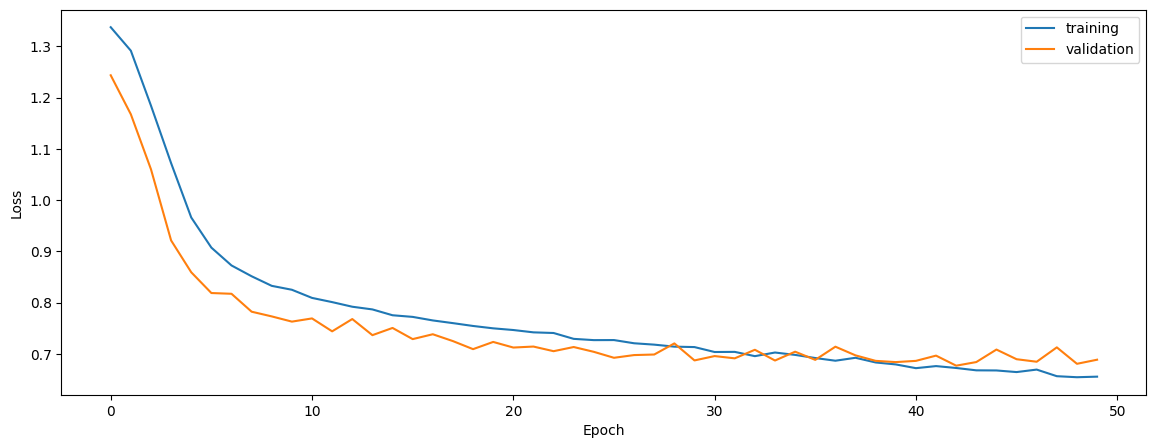

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


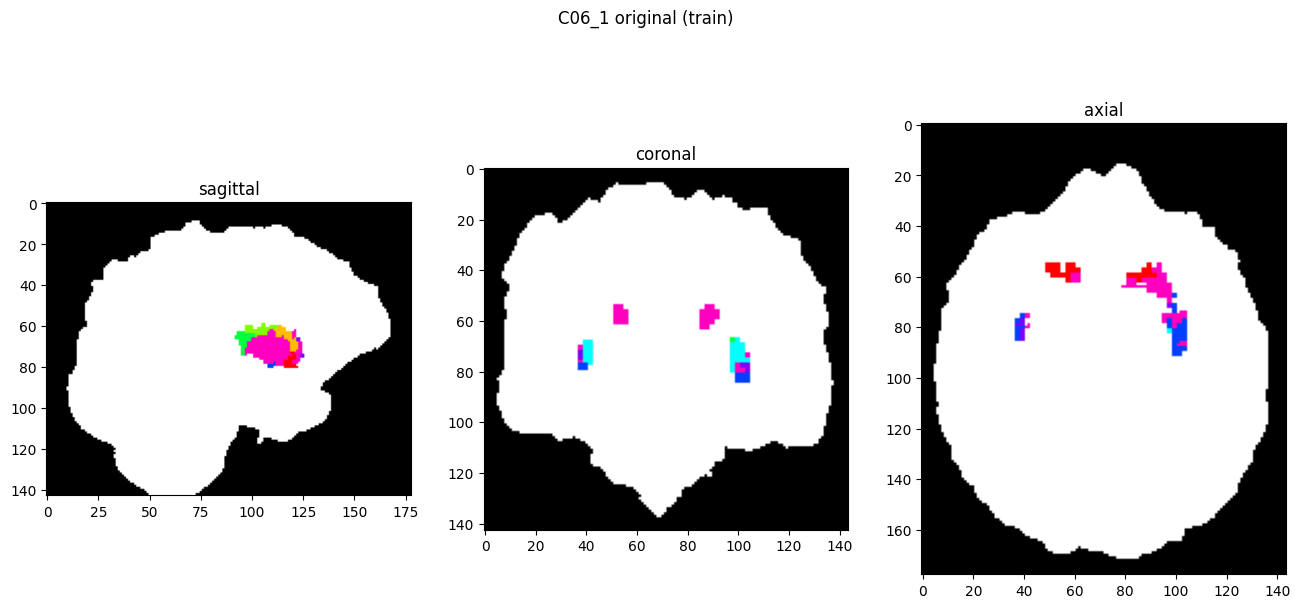

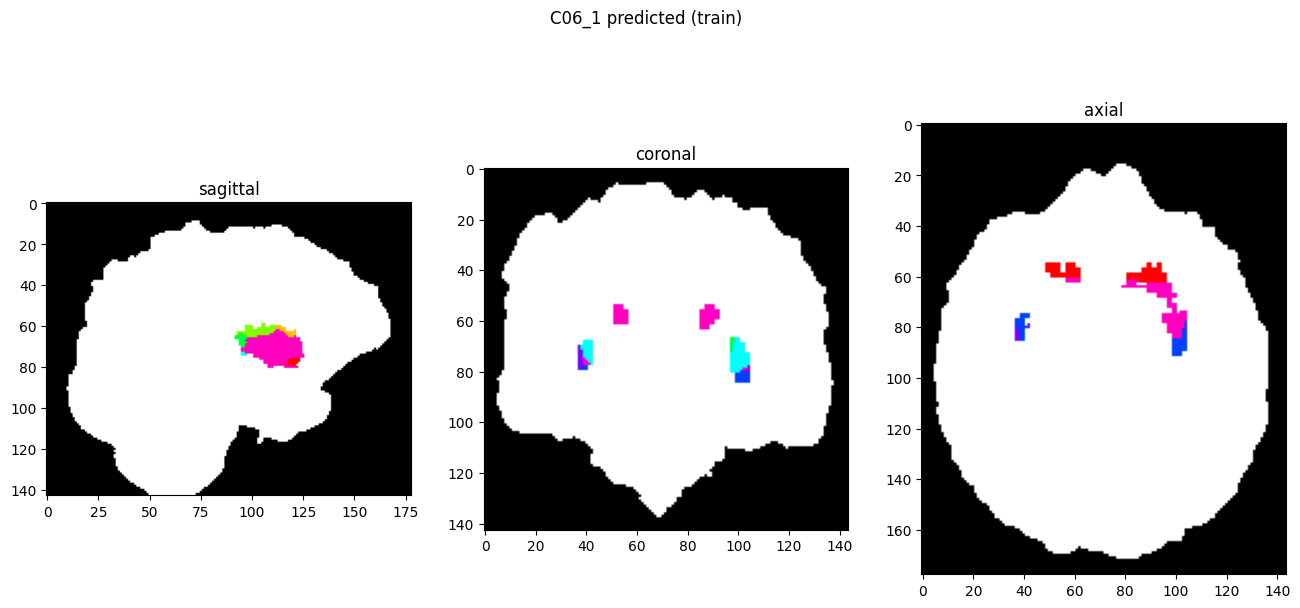

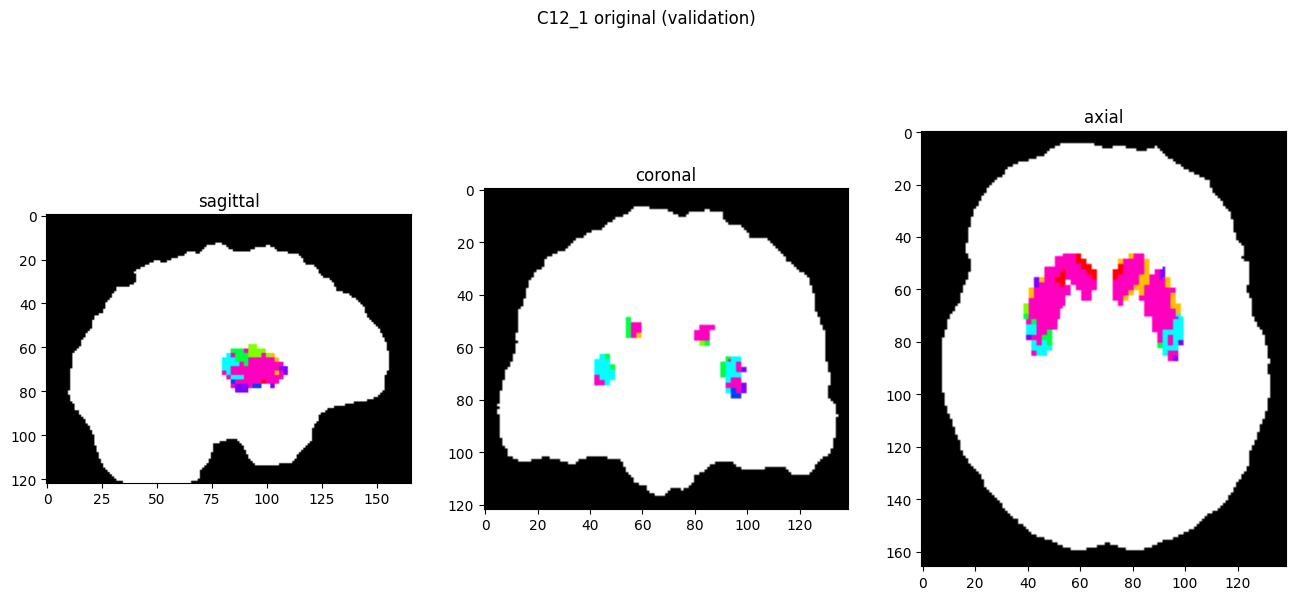

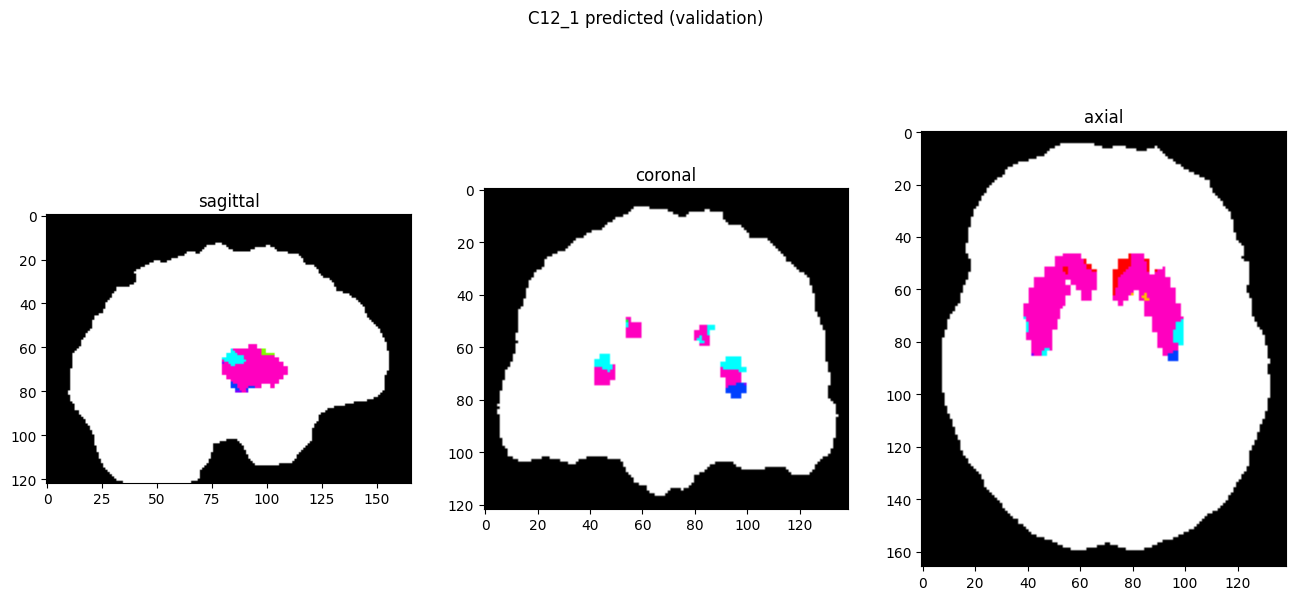

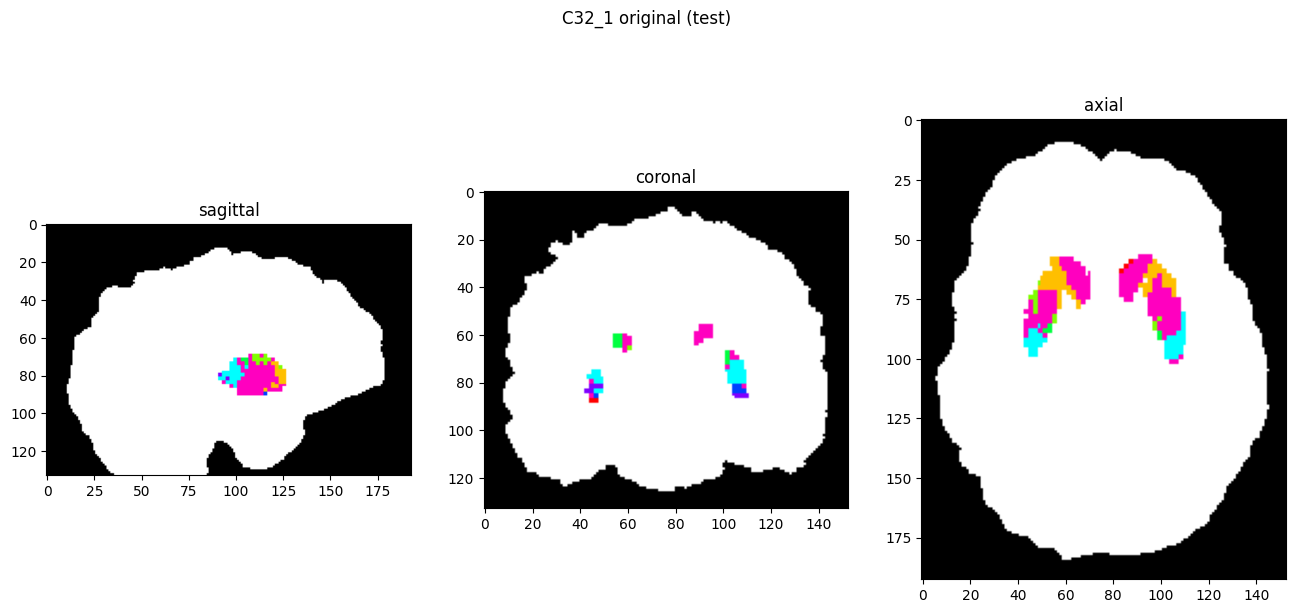

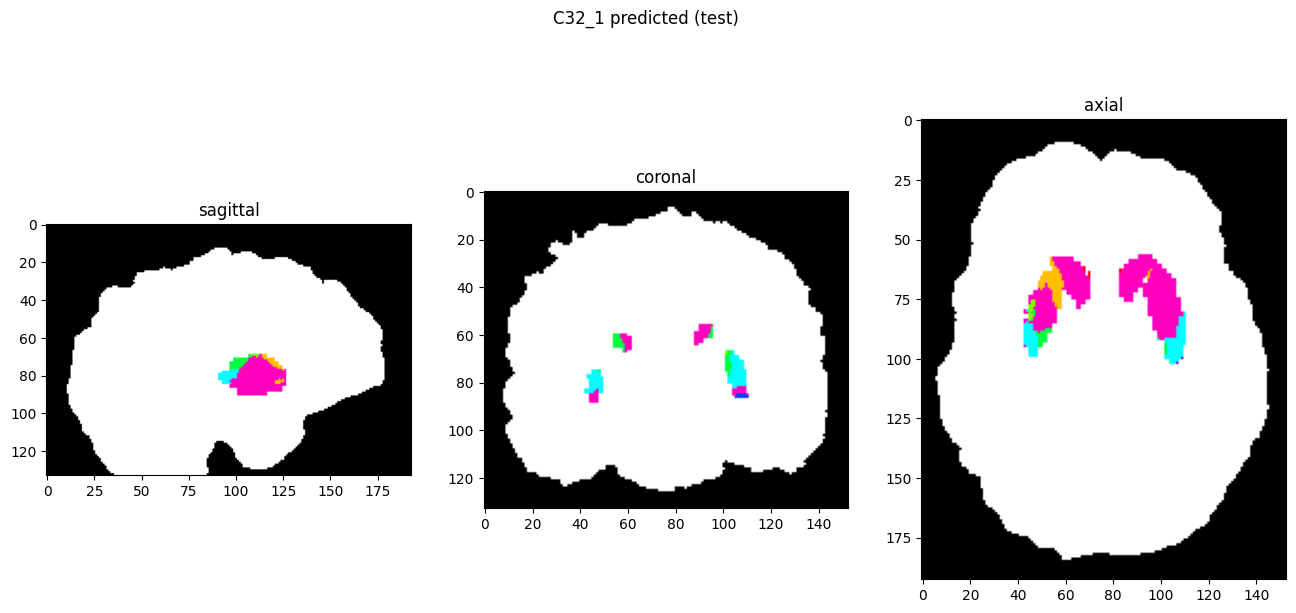

In [10]:
showResults(model, gen, threshold=0)